<img src="images/logo/eooffshore_banner.png" width="48%" />&nbsp;

<img src="images/logo/seai.png" width="25%" /> <span /> <img src="images/logo/ucd.png" width="7%" />

# Offshore Wind in Irish Areas Of Interest

## Introduction

In recent years, a variety of initiatives have emerged that provide public access to wind speed data products, which have potential for application in wind atlas development and offshore wind farm assessment. Combining products from multiple data providers is challenging due to differences in spatial and temporal resolution, product access, and product formats. In particular, the associated large dataset sizes are significant obstacles to data retrieval, storage, and subsequent computation. The traditional process of retrieval and local analysis of a relatively small number of products is not readily scalable to accommodate longitudinal studies of wind farm Areas Of Interest (AOI).

This notebook demonstrates the utility of the [Pangeo](https://pangeo.io/) software ecosystem to address these issues in the development of offshore wind speed and power density estimates, increasing wind measurement coverage of offshore renewable energy assessment areas in the [Irish Continental Shelf (ICS)](https://www.marine.ie/Home/site-area/irelands-marine-resource/real-map-ireland) region. It uses the EOOffshore wind data catalog created for this region, consisting of a collection of analysis-ready, cloud-optimized (ARCO) datasets featuring up to 21 years of available in situ, reanalysis, and satellite observation wind data products. Scalable processing and visualization of this ARCO catalog is demonstrated with analysis of provided data variables and computation of new variables as required for AOIs, avoiding redundant storage and processing requirements for areas not under assessment.

| Data | Provider | Time | # Products | Products Size (GB) | ARCO Zarr (GB) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| [ASCAT Near Real Time L3 Sea Winds](https://resources.marine.copernicus.eu/product-detail/WIND_GLO_WIND_L3_NRT_OBSERVATIONS_012_002) | [Copernicus Marine Service](https://marine.copernicus.eu/) | 2016-01 to 2021-09 | 324 | 16 | 11 |
| [ASCAT Reprocessed L3 Sea Winds](https://resources.marine.copernicus.eu/product-detail/WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005) | [Copernicus Marine Service](https://marine.copernicus.eu/) | 2007-01 to 2021-07 | 412 | 21 | 14 |
| [CCMP Wind V2.1 NRT](http://www.remss.com/measurements/ccmp/) | [Remote Sensing Systems](http://www.remss.com) | 2015-01 to 2021-09 | 2,436 | 109 | 0.5 |
| [ERA5 Hourly Single Level](https://cds.climate.copernicus.eu/cdsapp##!/dataset/reanalysis-era5-single-levels) | [Copernicus Climate Change Service](https://climate.copernicus.eu/) | 2001-01 to 2021-09 | 249 | 10 | 16 |
| [Met Éireann Re-Analysis (MÉRA)](https://www.met.ie/climate/available-data/mera) | [Met Éireann](https://www.met.ie/about-us) | 2001-01 to 2016-12 | 1,920 | 226 | 196 |
| [Sentinel-1 L2 OCN](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-2-algorithms) | [Copernicus Open Access Hub](https://scihub.copernicus.eu/); [Alaska Satellite Facility](https://asf.alaska.edu/) | 2015-06 to 2021-09 | 17,698 | 241 | 12 |
| [Irish Weather Buoy Network](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos) | [Marine Institute](https://www.marine.ie/Home/home) | 2001-05 to 2021-09 | 1 | 0.08 | n/a |

The following sections describe:

1. EOOffshore catalog data sets loading. Catalog creation is described in the following notebooks:
   * [ASCAT Wind Data for Irish Continental Shelf region](./ASCAT_ICS_Wind_Data.ipynb)
   * [CCMP Wind Data for Irish Continental Shelf region](./CCMP_ICS_Wind_Data.ipynb)
   * [ERA5 Wind Data for Irish Continental Shelf region](./ERA5_ICS_Wind_Data.ipynb)
   * [MÉRA Wind Data for Irish Continental Shelf region](./MERA_ICS_Wind_Data.ipynb)
   * [NEWA Wind Data for Irish Continental Shelf region](./NEWA_ICS_Wind_Data.ipynb)
   * [Sentinel-1 Wind Data for Irish Continental Shelf region](./Sentinel-1_ICS_Wind_Data.ipynb)
1. Initial AOI assessment using catalog wind speed and direction.
1. Extrapolation of catalog wind speed to typical [wind turbine hub heights](https://www.wind-energy-the-facts.org/hub-height.html).
1. Wind power density estimation.

**How to cite:** O'Callaghan, D. and McBreen, S.: Scalable Offshore Wind Analysis With Pangeo, EGU General Assembly 2022, Vienna, Austria, 23–27 May 2022, EGU22-2746, [https://doi.org/10.5194/egusphere-egu22-2746](https://doi.org/10.5194/egusphere-egu22-2746), 2022.

--------------------------------------------------
## Load EOOffshore Catalog Data

Imports required for subsequent processing

In [1]:
%matplotlib inline
from abc import ABC, abstractmethod
import cartopy.crs as ccrs
from dataclasses import dataclass, field
from datetime import datetime
from functools import lru_cache
import geopandas as gpd
from intake import Catalog, open_catalog
import json
import math
import matplotlib as mpl
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
from scipy.special import gamma
from scipy.stats import weibull_min
import seaborn as sns
import shapely.geometry as sgeom
from sklearn.neighbors import NearestNeighbors
from typing import Dict, List, Tuple
from windrose import WindroseAxes
import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 5]
sns.set_style('whitegrid', {'axes.labelcolor': '0', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

import warnings
warnings.filterwarnings('ignore')

-----------------------------------------------
### Open the catalog

All EOOffshore data sets, for example, the [ERA5 Zarr store](./ERA5_ICS_Wind_Data.ipynb), are accessible using the EOOffshore [Intake](https://intake.readthedocs.io/en/latest/) catalog. Each [catalog](https://intake.readthedocs.io/en/latest/catalog.html) entry provides a description and metadata associated with the corresponding data set, defined in a [YAML configuration file](https://intake.readthedocs.io/en/latest/catalog.html#yaml-format). The EOOffshore catalog configuration was originally influenced by the [Pangeo Cloud Data Store atmosphere.yaml catalog configuration](https://github.com/pangeo-data/pangeo-datastore/blob/master/intake-catalogs/atmosphere.yaml). 

In [2]:
catalog = open_catalog('data/intake-catalogs/eooffshore_ics.yaml')

-------------------------------------------------
### Load the catalog Zarr stores

Intake catalog entries typically specify a [driver](https://intake.readthedocs.io/en/latest/catalog.html#driver-selection) to be used when loading the corresponding data set. The ASCAT entries specify [`intake_xarray.xzarr.ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource), a driver implementation provided by the [intake-xarray](https://intake-xarray.readthedocs.io/) library. This enables NetCDF and Zarr data sets to be loaded using [xarray](https://docs.xarray.dev/en/stable/index.html), a library for processing N-D labeled arrays and datasets. As xarray labels take the form of dimensions, coordinates and attributes on top of [NumPy](https://numpy.org/)-like arrays, it is particularly suited to data sets such as ASCAT whose variables feature latitude/longitude grid coordinates.

This intake driver will load the associated dataset into an [`xarray.Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). To enable support for potentially large data sets, the [`to_dask()`](https://intake.readthedocs.io/en/latest/quickstart.html?#working-with-dask) function is used to load the underlying variable arrays with [Dask](https://docs.dask.org/en/latest/), a parallel, out-of-core computing library. The [`ZarrSource`](https://intake-xarray.readthedocs.io/en/latest/api.html#intake_xarray.xzarr.ZarrSource) implementation will load the data set variables into [Dask arrays](https://docs.dask.org/en/latest/array.html), which will be loaded and processed in parallel as [chunks](https://docs.dask.org/en/latest/array.html) during subsequent computation. Variable chunk sizes have been specified during Zarr store creation.

Here, a number of utility classes are created to enable processing of catalog entries throughout the notebook:
1. All data sets are loaded by an `EooffshoreDataset` instance.
1. `XarrayEooffshoreDataset` supports Zarr store data sets:
   * [`to_dask()`](https://intake.readthedocs.io/en/latest/quickstart.html?#working-with-dask) loads the store
   * Variables are renamed if required, ensuring consistent names for all data sets, for example, `wind_speed` and `wind_direction`.
   * Longitude rotation from [0, 360] to [-180, 180] is performed if required
1. `CurvilinearEooffshoreDataset` supports Zarr stores featuring two-dimensional curvilinear grids:
   * [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html) does not support selection from two-dimensional curvilinear grids, for example, using latitude/longitude coordinates
   * Two-dimenional grid selection is enabled by the use of a K-Nearest Neighbours (kNN) learner from [scikit-learn](https://scikit-learn.org/stable/index.html) ([`sklearn.neighbors.NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)), which is fit with the grid coordinates when the Zarr store is loaded. To match the behaviour of [`xarray.DataArray.sel(..., method='nearest')`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html), `k` is set to 1 to return the nearest coordinates to the specified parameters.
1. `NewaOffshoreDataset` supports the multiple AOI NEWA Zarr stores contained in the catalog, as described in the [NEWA Wind Data for Irish Continental Shelf region](./NEWA_ICS_Wind_Data.ipynb) notebook.
1. `WindfarmEooffshoreDataset` provides access to a synthetic wind farm AOI data set created for the EOOffshore project, and functionality for selecting corresponding data subsets from the Zarr stores, using [GeoPandas](https://geopandas.org/en/stable/) and [regionmask](https://regionmask.readthedocs.io).
1. `IwbEooffshoreDataset` provides access to an EOffshore data set containing observations from the [Irish Weather Buoy Network](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos), and functionality for selecting corresponding data subsets from the Zarr stores.

In [3]:
# Wind turbine speed cut-in/cut-out limits (m/s)
CUT_IN_WIND_SPEED = 3
CUT_OUT_WIND_SPEED = 25

@dataclass
class EooffshoreDataset:
    """Base EOOffshore dataset class, associated with a single Intake Catalog entry"""
    name: str # Short name used in plots
    catalog: Catalog = field(repr=False, hash=False, compare=False)
    dataset_id: str # Catalog identifier

    def aoi_dataset(self, aoi: str):
        """Retrieve dataset subset for specified area of interest if required"""
        return self

@dataclass
class XarrayEooffshoreDataset(EooffshoreDataset):
    """Dataset backed by a Zarr store, NetCDF file etc."""
    dataset: xr.Dataset = field(init=False, hash=False, compare=False, repr=False)
    rename_variables: dict[str, str] = None
    rotate_longitude: bool = False # Rotate from [0, 360] to [-180, 180]
    # If there are any missing values for a cell for the data set time dimension, e.g. SAR data set observations, any cell values filtering based on quality flags etc.
    incomplete_time_series: bool = False     
    
    def __post_init__(self):
        """Load the dataset from the Intake catalog, and perform some common initialisation"""
        ds = self.catalog[self.dataset_id].to_dask()
        
        # Enable consistent variable naming
        if self.rename_variables:
            ds = ds.rename(self.rename_variables)
            
        # Add a 'Season' coordinate derived from the 'time' coordinate
        self.dataset = ds.assign_coords({'Season': ds.time.dt.season})

    def sel_grid_nearest(self, latitude: float, longitude: float):
        """Select a subset of the dataset, nearest to the specified coordinates"""
        if self.rotate_longitude:
            longitude %= 360     
        return self._nearest_latitude_longitude(latitude, longitude)

    def _nearest_latitude_longitude(self, latitude: float, longitude: float):
        """Select a subset of the associated 1-D grid dataset, nearest to the specified coordinates"""
        return self.dataset.sel(longitude=longitude, latitude=latitude, method='nearest')

@dataclass
class CurvilinearEooffshoreDataset(XarrayEooffshoreDataset):
    """
    Additional functionality to handle issue where `xarray.Dataset.sel()` doesn't support calls to sel() for 2-D latitude/longitude grids. 
    This is enabled by the use of a K-Nearest Neighbours (kNN) learner
    """
    grid_neighbours: NearestNeighbors = field(init=False, hash=False, compare=False, repr=False)

    def __post_init__(self):
        """Fit nearest neighbours learner using dataset latitude/longitude grid, used in subsequent calls to sel_grid_nearest()"""
        super().__post_init__()
        
        longitude = self.dataset.longitude
        latitude = self.dataset.latitude

        self.grid_neighbours = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(np.stack((longitude.values.reshape(-1,), latitude.values.reshape(-1,)), axis=1))

    def _nearest_latitude_longitude(self, latitude: float, longitude: float):
        """Select a subset of the associated 2-D grid dataset, using the top kNN (k=1) neighbours to the specified coordinates"""
        # Select one neighbour similar to `xarray.Dataset.sel(..., method='nearest')`
        k = 1
        distances, indices = self.grid_neighbours.kneighbors(np.array([longitude, latitude]).reshape(1,-1), n_neighbors=k)
        yindex, xindex = np.unravel_index(indices, self.dataset.latitude.shape)
        ydim, xdim = self.dataset.latitude.dims
        return self.dataset.isel({ydim: yindex[0][0], xdim: xindex[0][0]})

@dataclass
class NewaEooffshoreDataset(EooffshoreDataset):
    """Additional functionality required for processing NEWA datasets. It acts as a mapper from AOI to catalog `xarray.Dataset`""" 
    aoi_mapping: Dict[str, str] = None
    datasets: Dict[str, CurvilinearEooffshoreDataset] = field(init=False, hash=False, compare=False)
    
    def __post_init__(self):
        """Preprocessing of the datasets loaded from the Intake catalog"""
        self.datasets = {aoi: self._load_newa_dataset(self.name, self.catalog, dataset_id) for aoi, dataset_id in self.aoi_mapping.items()}

    def aoi_dataset(self, aoi: str) -> EooffshoreDataset:
        """Retrieve dataset subset for area of interest"""
        return self.datasets.get(aoi, None) 

    @classmethod
    @lru_cache
    def _load_newa_dataset(cls, name: str, catalog: Catalog, dataset_id: str):
        """Loads Zarr store associated with an AOI"""
        newa_ds = CurvilinearEooffshoreDataset(name=name, 
                                               catalog=catalog, 
                                               dataset_id=dataset_id,
                                               rename_variables={'WS': 'wind_speed', 
                                                                 'WD': 'wind_direction', 
                                                                 'PD': 'power_density', 
                                                                 'XLAT': 'latitude', 
                                                                 'XLON': 'longitude'}
                                              )

        ds = newa_ds.dataset.drop(['south_north', 'west_east'])

        # Add provided 10m wind variable data to corresponding variable with a height dimension
        wind_variables = {}
        for variable_name_10m, variable_name in {'WS10': 'wind_speed', 'WD10': 'wind_direction'}.items(): 
            wind_variables[variable_name] = xr.concat((ds[variable_name], ds[variable_name_10m].assign_coords(height=10).expand_dims(['height'])), dim='height').sortby('height')
        ds = ds.reindex({'height': wind_variables['wind_speed'].height}).chunk({'height':1})
        for variable_name, wind_variable in wind_variables.items():
            ds[variable_name] = wind_variable
        
        newa_ds.dataset = ds
        return newa_ds
    
@dataclass
class WindfarmEooffshoreDataset(EooffshoreDataset):
    """Wind farm location shapefile dataset"""
    dataframe: gpd.GeoDataFrame = field(init=False, hash=False, compare=False, repr=False)
    windfarms: List[str] = None 
    windfarm_mask: xr.DataArray = field(init=False, hash=False, compare=False, repr=False)
    selection_buffer: float = 0.1

    def __post_init__(self):
        """Load the wind farm dataset from the catalog shapefile, and create a corresponding mask used for subsequent dataset subset selection"""
        self.dataframe = gpd.read_file(self.catalog[self.dataset_id].urlpath).to_crs("EPSG:4326")
        if not self.windfarms:
            self.windfarms = self.dataframe.Name.to_list()
        else:
            self.dataframe = self.dataframe[self.dataframe.Name.isin(self.windfarms)]
        
        # Higher-resolution mask that's used when dataset mask is insufficient during subsequent windfarm AOI retrieval
        self.windfarm_mask = regionmask.mask_geopandas(self.dataframe, np.arange(-11, -5, .007), np.arange(55.42, 51.0, -.007)).rename({'lat': 'latitude', 'lon':'longitude'})
        
    def windfarm_dataset(self, windfarm: str, dataset: XarrayEooffshoreDataset, spatial_mean: bool = False) -> xr.Dataset:
        """Select a dataset subset for the specified wind farm, using the wind farm dataset mask"""
        windfarm_id = self.dataframe[self.dataframe.Name==windfarm].id.item()
        ds = dataset.aoi_dataset(windfarm).dataset
    
        dataset_windfarm_mask = regionmask.mask_geopandas(self.dataframe, ds, lon_name='longitude', lat_name='latitude')

        # If the wind farm is present in the dataset mask, use that directly
        # Otherwise find the closest dataset coordinate to the high-res mask wind farm coordinates
        if windfarm_id in np.unique(dataset_windfarm_mask):
            windfarmds = ds.where(dataset_windfarm_mask==windfarm_id, drop=True)
        else:
            highresmask = self.windfarm_mask
            windfarm_lat = highresmask.where(highresmask==windfarm_id, drop=True).latitude.values
            windfarm_lon = highresmask.where(highresmask==windfarm_id, drop=True).longitude.values
            if dataset.rotate_longitude:
                windfarm_lon %= 360            
            windfarmds = ds.where((ds.latitude >= windfarm_lat.min() - self.selection_buffer) & (ds.latitude <= windfarm_lat.max() + self.selection_buffer) & (ds.longitude >= windfarm_lon.min() - self.selection_buffer) & (ds.longitude <= windfarm_lon.max() + self.selection_buffer), drop=True)
            
        if spatial_mean:
            # Calculate the mean for all wind farm subset coordinates
            # Both 1-d and 2-d grid dimensions are supported
            windfarmds = windfarmds.mean(dim=set(ds.latitude.dims) | set(ds.longitude.dims), keep_attrs=True) 
        return windfarmds.assign_coords(Dataset=dataset.name).expand_dims('Dataset')

    def all_windfarm_datasets(self, dataset: EooffshoreDataset, spatial_mean: bool=True) -> xr.Dataset:
        """Select a subset of the specified dataset for each of the available wind farms"""
        return xr.concat([self.windfarm_dataset(windfarm, dataset, spatial_mean) for windfarm in self.windfarms], dim='Windfarm')
    
@dataclass
class Buoy:
    name: str
    longitude: float
    latitude: float
    
@dataclass
class IwbEooffshoreDataset(EooffshoreDataset):
    """Irish Weather Buoy dataset"""
    dataframe: pd.DataFrame = field(init=False, hash=False, compare=False, repr=False)
    buoy_coordinates: Dict[str, Buoy] = field(init=False)
    
    def __post_init__(self):
        """Preprocessing of the data frame loaded from the Intake catalog"""
        self.dataframe = self.catalog[self.dataset_id].read()
        # Retain only buoys still in use
        self.dataframe = self.dataframe[self.dataframe.station_id.isin(['M2', 'M3', 'M4', 'M5', 'M6'])].rename(columns={'longitude (degrees_east)': 'longitude', 'latitude (degrees_north)': 'latitude'})
        self.buoy_coordinates = {name: Buoy(name=name, longitude=x['longitude'], latitude=x['latitude']) for name, x in self.dataframe.groupby('station_id')[['longitude', 'latitude']].agg(['unique']).applymap(lambda x:x[0]).droplevel(1, axis=1).T.to_dict().items()}

    @property
    def buoys(self):
        return list(self.buoy_coordinates.keys())
    
    def buoy_dataset(self, buoy: str, dataset: XarrayEooffshoreDataset) -> xr.Dataset:
        """Select a dataset subset using the coordinates of the specified buoy"""
        buoyds = None
        try:
            buoyds = dataset.aoi_dataset(aoi=buoy).sel_grid_nearest(longitude=self.buoy_coordinates[buoy].longitude, latitude=self.buoy_coordinates[buoy].latitude)
            buoyds = buoyds.assign_coords(Dataset=dataset.name).expand_dims('Dataset')
        except:
            # If an AOI can't be found in the dataset, ignore it
            pass
        return buoyds

----------------------------------------------------------------
#### Load the ASCAT REProcessed store

* Data is provided at 10m above surface level (`height` dimension).
* The original `wind_to_dir` variable is rotated by 180 degrees to generate a (from) `wind_direction`, consistent with the other data sets.
* It is possible to filter ASCAT data the provided quality flag masks (`wvc_quality_flag`). However, as this would result in no data for certain AOIs located in Irish coastal waters, in particular, Irish Sea AOIs, no filtering has been performed for this notebook. 
* The [ASCAT Wind Data for Irish Continental Shelf region](./ASCAT_ICS_Wind_Data.ipynb) notebook describes the store creation and quality flags.

In [4]:
catalog.eooffshore_ics_cms_WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005_MetOp_ASCAT

eooffshore_ics_cms_WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005_MetOp_ASCAT:
  args:
    storage_options: null
    urlpath: /data/eo/zarr/cmems/WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005/eooffshore_ics_cmems_WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005_MetOp_ASCAT.zarr
  description: EOOffshore Project 2016 - 2021 Concatenated Copernicus Marine Service
    WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_002 MetOp ASCAT Ascending/Descending products,
    for the Irish Continental Shelf. Original products time coordinates have been
    replaced with the satellite/pass measurement_time values. Generated using E.U.
    Copernicus Marine Service Information; https://doi.org/10.48670/moi-00183
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmosphere
    - wind
    - metop
    - ascat
    - ocean
    - cmems
    title: CMEMS Global Ocean - Wind - METOP-A/B ASCAT - 12km daily Ascending/Descending
      V2 combined 

In [5]:
ascat = XarrayEooffshoreDataset(name='ASCAT', 
                                catalog=catalog, 
                                dataset_id='eooffshore_ics_cms_WIND_GLO_WIND_L3_REP_OBSERVATIONS_012_005_MetOp_ASCAT',
                                rotate_longitude=True,
                                rename_variables={'lat': 'latitude', 'lon': 'longitude'},
                                incomplete_time_series=True
                                )
ascat.dataset['wind_direction'] = (ascat.dataset.wind_to_dir + 180) % 360
ascat.dataset

<xarray.Dataset>
Dimensions:                   (time: 12467, latitude: 97, longitude: 208,
                               height: 1)
Coordinates:
  * height                    (height) int64 10
  * latitude                  (latitude) float32 46.06 46.19 ... 57.94 58.06
  * longitude                 (longitude) float32 334.1 334.2 ... 359.8 359.9
  * time                      (time) datetime64[ns] 2007-01-01T22:00:20.35560...
    Season                    (time) <U3 'DJF' 'DJF' 'DJF' ... 'JJA' 'JJA' 'JJA'
Data variables: (12/27)
    air_density               (time, latitude, longitude) float32 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    bs_distance               (time, latitude, longitude) float32 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    eastward_model_stress     (time, latitude, longitude) float64 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    eastward_stress           (time, latitude, longitude) float64 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    eastward_wind             (time, latitude, longitude) float32 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    model_stress_curl         (time, latitude, longitude) float64 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    ...                        ...
    wind_speed                (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 1500, 97, 208), meta=np.ndarray>
    wind_stress_magnitude     (time, latitude, longitude) float64 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    wind_to_dir               (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 1500, 97, 208), meta=np.ndarray>
    wvc_index                 (time, latitude, longitude) float32 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    wvc_quality_flag          (time, latitude, longitude) float64 dask.array<chunksize=(1500, 97, 208), meta=np.ndarray>
    wind_direction            (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 1500, 97, 208), meta=np.ndarray>
Attributes: (12/36)
    Conventions:                      CF-1.6
    History:                          Translated to CF-1.0 Conventions by Net...
    comment:                          Orbit period and inclination are consta...
    contents:                         ovw
    creation_date:                    2021-11-05
    creation_time:                    19:16:35
    ...                               ...
    start_date:                       2021-07-31
    start_time:                       00:00:00
    stop_date:                        2021-07-31
    stop_time:                        23:59:58
    title:                            Global Ocean - Wind - METOP-A ASCAT - 1...
    title_short_name:                 ASCATA-L3-Coastal

----------------------------------------------------------------
#### Load the CCMP store

* Data is provided at 10m above surface level (`height` dimension).
* Retain data having at least one observation used to derive CCMP wind vector components. 
* The [CCMP Wind Data for Irish Continental Shelf region](./CCMP_ICS_Wind_Data.ipynb) notebook describes the store creation and `nobs` filtering.

In [6]:
catalog.eooffshore_ics_ccmp_v02_1_nrt_wind

eooffshore_ics_ccmp_v02_1_nrt_wind:
  args:
    storage_options: null
    urlpath: /data/eo/zarr/ccmp/v02.1.NRT/eooffshore_ics_ccmp_v02_1_nrt_wind.zarr
  description: EOOffshore Project 2015 - 2021 Concatenated CCMP v0.2.1.NRT 6-hourly
    wind products provided by Remote Sensing Systems (RSS), for Irish Continental
    Shelf. Wind speed and direction have been calculated from the uwnd and vwnd variables.
    CCMP Version-2.0 vector wind analyses are produced by Remote Sensing Systems.
    Data are available at www.remss.com.
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmosphere
    - wind
    - ccmp
    - ocean
    title: EOOffshore Project 2015 - 2021 Concatenated CCMP v0.2.1.NRT 6-hourly wind
      products provided by Remote Sensing Systems (RSS), for Irish Continental Shelf
    url: https://www.remss.com/measurements/ccmp/


In [7]:
ccmp = XarrayEooffshoreDataset(name='CCMP', catalog=catalog, dataset_id='eooffshore_ics_ccmp_v02_1_nrt_wind', rotate_longitude=True, incomplete_time_series=True)
ccmp.dataset = ccmp.dataset.where(ccmp.dataset.nobs >= 1)
ccmp.dataset

<xarray.Dataset>
Dimensions:         (time: 9744, latitude: 50, longitude: 86, height: 1)
Coordinates:
  * height          (height) int64 10
  * latitude        (latitude) float32 45.88 46.12 46.38 ... 57.62 57.88 58.12
  * longitude       (longitude) float32 333.9 334.1 334.4 ... 354.6 354.9 355.1
  * time            (time) datetime64[ns] 2015-01-16 ... 2021-09-30T18:00:00
    Season          (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'SON' 'SON' 'SON'
Data variables:
    nobs            (time, latitude, longitude) float32 dask.array<chunksize=(8000, 50, 86), meta=np.ndarray>
    uwnd            (time, latitude, longitude) float32 dask.array<chunksize=(8000, 50, 86), meta=np.ndarray>
    vwnd            (time, latitude, longitude) float32 dask.array<chunksize=(8000, 50, 86), meta=np.ndarray>
    wind_direction  (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 8000, 50, 86), meta=np.ndarray>
    wind_speed      (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 8000, 50, 86), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                    CF-1.6
    comment:                        none
    contact:                        Remote Sensing Systems, support@remss.com
    contributor_name:               Carl Mears, Joel Scott, Frank Wentz, Ross...
    contributor_role:               Co-Investigator, Software Engineer, Proje...
    creator_email:                  support@remss.com
    ...                             ...
    publisher_email:                support@remss.com
    publisher_name:                 Remote Sensing Systems
    publisher_url:                  http://www.remss.com/
    references:                     Mears et al., Journal of Geophysical Rese...
    summary:                        CCMP_RT V2.1 has been created using the s...
    title:                          RSS CCMP_RT V2.1 derived surface winds (L...

----------------------------------------------------------------
#### Load the ERA5 store

* **Data is provided at both 10m and 100m above surface level (`height` dimension).**
* The [ERA5 Wind Data for Irish Continental Shelf region](./ERA5_ICS_Wind_Data.ipynb) notebook describes the store creation.

In [8]:
catalog.eooffshore_ics_era5_single_level_hourly_wind

eooffshore_ics_era5_single_level_hourly_wind:
  args:
    storage_options: null
    urlpath: /data/eo/zarr/cds/era5/eooffshore_ics_era5_single_level_hourly_wind.zarr
  description: EOOffshore Project 2001 - 2021 Concatenated wind variable products
    from Copernicus Climate Change Service data set "ERA5 hourly data on single levels
    from 1979 to present", for Irish Continental Shelf. Wind speed and direction have
    been calculated from the uX and vX variables. Generated using Copernicus Climate
    Change Service information [2001 - 2021].
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmosphere
    - wind
    - era5
    - cds
    - ocean
    title: 2001 - 2021 Concatenated wind variable products from Copernicus Climate
      Change Service data set 'ERA5 hourly data on single levels from 1979 to present',
      for Irish Continental Shelf.
    url: https://cds.climate.copernicus.eu/c

In [9]:
era5 = XarrayEooffshoreDataset(name='ERA5', catalog=catalog, dataset_id='eooffshore_ics_era5_single_level_hourly_wind')
era5.dataset

<xarray.Dataset>
Dimensions:         (time: 181872, latitude: 49, longitude: 85, height: 2)
Coordinates:
  * height          (height) int64 10 100
  * latitude        (latitude) float32 58.0 57.75 57.5 57.25 ... 46.5 46.25 46.0
  * longitude       (longitude) float32 -25.9 -25.65 -25.4 ... -5.4 -5.15 -4.9
  * time            (time) datetime64[ns] 2001-01-01 ... 2021-09-30T23:00:00
    Season          (time) <U3 'DJF' 'DJF' 'DJF' 'DJF' ... 'SON' 'SON' 'SON'
Data variables:
    fsr             (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    lsm             (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    p140209         (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    u10             (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    u100            (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    v10             (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    v100            (time, latitude, longitude) float32 dask.array<chunksize=(50000, 25, 25), meta=np.ndarray>
    wind_direction  (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 50000, 25, 25), meta=np.ndarray>
    wind_speed      (height, time, latitude, longitude) float32 dask.array<chunksize=(1, 50000, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:                    CF-1.6
    eooffshore_zarr_creation_time:  2022-05-13T11:50:24Z
    eooffshore_zarr_details:        EOOffshore Project: Concatenated wind var...
    history:                        2021-10-15 20:08:53 GMT by grib_to_netcdf...

----------------------------------------------------------------
#### Load the MÉRA store

* **Data is provided at multiple heights above surface level (`height` dimension).**
* The [MÉRA Wind Data for Irish Continental Shelf region](./MERA_ICS_Wind_Data.ipynb) notebook describes the store creation.

In [10]:
catalog.eooffshore_ics_mera_wind_ANALYSIS

eooffshore_ics_mera_wind_ANALYSIS:
  args:
    storage_options: null
    urlpath: /meradata/eo/zarr/mera/eooffshore_ics_mera_wind_ANALYSIS.zarr
  description: "EOOffshore Project 2001 - 2016 Concatenated 3-hourly ANALYSIS wind\
    \ variable products from the Met \xC9ireann ReAnalysis (M\xC9RA) data set, for\
    \ Irish Continental Shelf. Wind speed and direction have been calculated from\
    \ the source u and v variables. Copyright Met \xC9ireann. Source www.met.ie. Licence\
    \ Statement - This data is published under a Creative Commons Attribution 4.0\
    \ International (CC BY 4.0). https://creativecommons.org/licenses/by/4.0/ . Disclaimer\
    \ - Met \xC9ireann does not accept any liability whatsoever for any error or omission\
    \ in the data, their availability, or for any loss or damage arising from their\
    \ use."
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmospher

In [11]:
mera = CurvilinearEooffshoreDataset(name='MÉRA', 
                                    catalog=catalog, 
                                    dataset_id='eooffshore_ics_mera_wind_ANALYSIS', 
                                    rotate_longitude=True,
                                   )
mera.dataset

<xarray.Dataset>
Dimensions:                        (height: 5, y: 489, x: 361, time: 46752)
Coordinates:
  * height                         (height) float64 10.0 50.0 80.0 100.0 125.0
    latitude                       (y, x) float64 dask.array<chunksize=(32, 32), meta=np.ndarray>
    longitude                      (y, x) float64 dask.array<chunksize=(32, 32), meta=np.ndarray>
  * time                           (time) datetime64[ns] 2001-01-01 ... 2016-...
    Season                         (time) <U3 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF'
Dimensions without coordinates: y, x
Data variables:
    atlas_maximum_yield_frequency  (height, y, x) float64 dask.array<chunksize=(2, 123, 181), meta=np.ndarray>
    atlas_mean_power_density       (height, y, x) float32 dask.array<chunksize=(5, 489, 361), meta=np.ndarray>
    atlas_mean_wind_speed          (height, y, x) float32 dask.array<chunksize=(5, 489, 361), meta=np.ndarray>
    atlas_operational_frequency    (height, y, x) float64 dask.array<chunksize=(2, 123, 181), meta=np.ndarray>
    atlas_weibull_scale            (height, y, x) float32 dask.array<chunksize=(5, 489, 361), meta=np.ndarray>
    atlas_weibull_shape            (height, y, x) float32 dask.array<chunksize=(5, 489, 361), meta=np.ndarray>
    wind_direction                 (height, time, y, x) float32 dask.array<chunksize=(1, 10000, 32, 32), meta=np.ndarray>
    wind_speed                     (height, time, y, x) float32 dask.array<chunksize=(1, 10000, 32, 32), meta=np.ndarray>
Attributes:
    Conventions:                    CF-1.7
    GRIB_centre:                    eidb
    GRIB_centreDescription:         Dublin
    GRIB_edition:                   1
    GRIB_subCentre:                 255
    eooffshore_zarr_creation_time:  2022-05-13T19:03:09Z
    eooffshore_zarr_details:        EOOffshore Project: Concatenated 3-hourly...
    geospatial_lat_max:             58.05
    geospatial_lat_min:             45.95
    geospatial_lon_max:             355.15
    geospatial_lon_min:             334.05
    institution:                    Dublin

----------------------------------------------------------------
#### Load the NEWA stores
* The `NewaEOOffshoreDataset` instance contains a map of AOI -> `CurvilinearEooffshoreDataset`, with each of the latter backed by a [`xarray.Dataset`](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html)
* **Data is provided at multiple heights above surface level (`height` dimension).**
* **Wind power density is provided.**
* The [NEWA Wind Data for Irish Continental Shelf region](./NEWA_ICS_Wind_Data.ipynb) notebook describes creation of the AOI stores.
* The `eooffshore_ics_newa_celticsea` Zarr store is highlighted as a representative NEWA dataset, and is used throughout this notebook.

In [12]:
newa = NewaEooffshoreDataset(name='NEWA', catalog=catalog, dataset_id='NEWA', aoi_mapping={'M2': 'eooffshore_ics_newa_irishsea', 
                                                                                           'M3': 'eooffshore_ics_newa_m3', 
                                                                                           'M4': 'eooffshore_ics_newa_m4', 
                                                                                           'M5': 'eooffshore_ics_newa_celticsea',
                                                                                           'Irish Sea 1': 'eooffshore_ics_newa_irishsea',
                                                                                           'Irish Sea 2': 'eooffshore_ics_newa_irishsea',
                                                                                           'Irish Sea 3': 'eooffshore_ics_newa_irishsea',
                                                                                           'Celtic Sea 1': 'eooffshore_ics_newa_celticsea',
                                                                                           'Celtic Sea 2': 'eooffshore_ics_newa_celticsea'})
newa.datasets['Celtic Sea 1'].dataset

<xarray.Dataset>
Dimensions:         (height: 5, time: 87648, south_north: 40, west_east: 54)
Coordinates:
  * height          (height) float64 10.0 50.0 75.0 100.0 150.0
    latitude        (south_north, west_east) float32 dask.array<chunksize=(40, 54), meta=np.ndarray>
    longitude       (south_north, west_east) float32 dask.array<chunksize=(40, 54), meta=np.ndarray>
  * time            (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:00:00
    Season          (time) <U3 dask.array<chunksize=(87648,), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    power_density   (time, height, south_north, west_east) float32 dask.array<chunksize=(40000, 1, 40, 54), meta=np.ndarray>
    RHO             (time, south_north, west_east) float32 dask.array<chunksize=(40000, 40, 54), meta=np.ndarray>
    Times           (time) |S20 dask.array<chunksize=(40000,), meta=np.ndarray>
    wind_direction  (time, height, south_north, west_east) float32 dask.array<chunksize=(40000, 1, 40, 54), meta=np.ndarray>
    WD10            (time, south_north, west_east) float32 dask.array<chunksize=(40000, 40, 54), meta=np.ndarray>
    wind_speed      (time, height, south_north, west_east) float32 dask.array<chunksize=(40000, 1, 40, 54), meta=np.ndarray>
    WS10            (time, south_north, west_east) float32 dask.array<chunksize=(40000, 40, 54), meta=np.ndarray>
    crs             (time) |S1 dask.array<chunksize=(40000,), meta=np.ndarray>
Attributes: (12/116)
    ADAPT_DT_MAX:                    15.0
    ADAPT_DT_MIN:                    3.0
    ADAPT_DT_START:                  13.0
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    ...                              ...
    WEST-EAST_GRID_DIMENSION:        Attribute edlided: Unsupported attribute...
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    eooffshore_zarr_creation_time:   2022-05-13T15:11:52Z
    eooffshore_zarr_details:         EOOffshore Project: Concatenated NEWA wi...
    history:                         2021-10-27 13:36:09 GMT Hyrax-1.16.0 htt...

----------------------------------------------------------------
#### Load the Sentinel-1 store

* Data is provided at 10m above surface level (`height` dimension).
* Retain grid data with:
  * Wind data quality in [0, 2], i.e. filter poor/bad quality data
  * 200+ SAR observations
  * Wind speed $\ge 1$
* The [Sentinel-1 Wind Data for Irish Continental Shelf region](./Sentinel-1_ICS_Wind_Data.ipynb) notebook describes the store creation and data filtering.

In [13]:
catalog.eooffshore_ics_level3_sentinel1_ocn

eooffshore_ics_level3_sentinel1_ocn:
  args:
    storage_options: null
    urlpath: /data/eo/zarr/scihub/s1_ocn/201501_202109/eooffshore_ics_level3_sentinel1_ocn.zarr
  description: EOOffshore Project 2015 - 2021 Concatenated Sentinel-1 Level 2 OCN
    wind (owiWind...) variable products from Copernicus, for Irish Continental Shelf.
    Products have been regridded with xESMF (bilinear) to a Level 3 grid, NW (-26,
    58), SE (-4, 46), grid resolution = 0.03 degrees. Contains modified Copernicus
    Sentinel data [2015 - 2021].
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: /opt/eooffshore/notebooks/datasets/data/intake-catalogs/
    tags:
    - atmosphere
    - wind
    - sentinel1
    - ocean
    title: Sentinel-1 L2 OCN owiWind variables regridded to level 3 Irish Continental
      Shelf grid (resolution = 0.03 degrees)
    url: https://sentinels.copernicus.eu/web/sentinel/ocean-wind-field-component


In [14]:
sentinel1 = CurvilinearEooffshoreDataset(name='Sentinel-1', 
                                         catalog=catalog, 
                                         dataset_id='eooffshore_ics_level3_sentinel1_ocn', 
                                         rename_variables={'owiWindDirection': 'wind_direction', 'owiWindSpeed': 'wind_speed'},
                                         incomplete_time_series=True
                                         )

sentinel1.dataset = sentinel1.dataset.where((sentinel1.dataset.owiWindQuality >= 0) & (sentinel1.dataset.owiWindQuality <= 2))

sentinel1.dataset['total_sar_observations'] = sentinel1.dataset.wind_speed.count('time').compute()

# Exclude cells with low numbers of observations, and very low 10m wind speed values, including 0s
# The latter have been identified in analysis of wind speed distributions, and appear to be redundant
sentinel1.dataset = sentinel1.dataset.where((sentinel1.dataset.total_sar_observations >= 200) & (sentinel1.dataset.wind_speed.sel(height=10) > 1))

sentinel1.dataset

<xarray.Dataset>
Dimensions:                 (time: 18545, height: 1, y: 401, x: 734)
Coordinates:
  * height                  (height) int64 10
    latitude                (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
    longitude               (y, x) float64 dask.array<chunksize=(401, 734), meta=np.ndarray>
  * time                    (time) datetime64[ns] 2015-06-07T18:21:04 ... 202...
    Season                  (time) <U3 'JJA' 'JJA' 'JJA' ... 'SON' 'SON' 'SON'
Dimensions without coordinates: y, x
Data variables:
    wind_direction          (time, height, y, x) float32 dask.array<chunksize=(18545, 1, 40, 40), meta=np.ndarray>
    owiWindQuality          (time, height, y, x) float64 dask.array<chunksize=(18545, 1, 40, 40), meta=np.ndarray>
    wind_speed              (time, height, y, x) float32 dask.array<chunksize=(18545, 1, 40, 40), meta=np.ndarray>
    total_sar_observations  (height, y, x, time) float64 dask.array<chunksize=(1, 40, 40, 18545), meta=np.ndarray>
Attributes:
    eooffshore_zarr_creation_time:  2022-05-13T14:02:25Z
    eooffshore_zarr_details:        EOOffshore Project: Concatenated Sentinel...

----------------------------------------------------------------
### Load AOI catalog data

This section describes the AOI data sets contained in the EOOffshore catalog:

1. [Irish Weather Buoy Network](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos) coordinates and data
1. Synthentic wind farm geometries

#### Load the Irish Weather Buoy Network data 

The [Irish Weather Buoy Network (IWB)](http://www.marine.ie/Home/site-area/data-services/real-time-observations/irish-weather-buoy-network-imos), managed by the [Marine Institute](https://www.marine.ie) in collaboration with Met Éireann and the UK Met Office, is a network of five operational buoys providing regular sea surface observations including wind speed and direction. Hourly IWB data for 2001 to 2021 was retrieved from the [Marine Institute ERDDAP server](https://erddap.marine.ie/erddap/index.html) and stored in a CSV file. The corresponding EOOffshore catalog entry is directly loaded into a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), retaining the wind speed, direction, and buoy coordinates data. 

In this notebook, the buoy coordinates are used to represent AOIs in visualisations of the Zarr store variables. Usage of the IWB wind data is provided in the [Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation](./Comparison_Wind_Power.ipynb) notebook.

In [15]:
iwb = IwbEooffshoreDataset(name='IWB', catalog=catalog, dataset_id='eooffshore_iwb_hourly')
iwb.dataframe[['station_id', 'longitude', 'latitude', 'WindDirection (degrees true)', 'WindSpeed (knots)']].head()

station_id  longitude  latitude  WindDirection (degrees true)  \
1889         M2    -5.4302   53.4836                         350.0   
1891         M2    -5.4302   53.4836                         360.0   
1894         M2    -5.4302   53.4836                         350.0   
1895         M2    -5.4302   53.4836                         360.0   
1897         M2    -5.4302   53.4836                         360.0   

      WindSpeed (knots)  
1889               7.98  
1891                NaN  
1894               7.98  
1895               8.95  
1897               7.98

In [16]:
iwb.buoy_coordinates

{'M2': Buoy(name='M2', longitude=-5.4302, latitude=53.4836),
 'M3': Buoy(name='M3', longitude=-10.548261, latitude=51.215956),
 'M4': Buoy(name='M4', longitude=-9.999136, latitude=54.999967),
 'M5': Buoy(name='M5', longitude=-6.704336, latitude=51.690425),
 'M6': Buoy(name='M6', longitude=-15.88135, latitude=53.07482)}

----------------------------------------------------------------
#### Load the synthentic wind farm shapefile 

A synthetic wind farm AOI data set was created for the EOOffshore project, illustrating potential wind farm locations in the Irish Sea and North Celtic Sea. The data set is a shapefile containing wind farm polygon geometries, which is loaded into a [`geopandas.GeoDataFrame`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). These polygons, along with the IWB buoy coordinates, are used to represent AOIs in visualisations of the Zarr store variables.

In [17]:
eoowindfarmds = WindfarmEooffshoreDataset(name='EOOffshore WF', catalog=catalog, dataset_id='eooffshore_windfarms')
eoowindfarmds.dataframe

id          Name                                           geometry
0   0   Irish Sea 1  POLYGON ((-5.95649 53.30998, -5.88964 53.30723...
1   1   Irish Sea 2  POLYGON ((-5.94810 52.90867, -5.88423 52.89672...
2   2   Irish Sea 3  POLYGON ((-6.12208 52.62162, -6.00372 52.61967...
3   3  Celtic Sea 1  POLYGON ((-7.59179 51.95014, -7.52819 51.95863...
4   4  Celtic Sea 2  POLYGON ((-8.05699 51.77563, -7.89472 51.82776...

------------------------------------------------
#### IWB buoy and synthetic wind farm AOI locations

Map plots of variables with grid coordinates may be generated using [xarray's plotting capabilities](https://docs.xarray.dev/en/latest/user-guide/plotting.html), and other libraries. To plot a variable:
* Specify a suitable projection using [Cartopy](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)
* Call the variable [`xarray.DataArray.plot()`](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html)
* Load the [ICS maritime limits](https://data.gov.ie/dataset/maritime-limits-irish-continental-shelf) geometry with [Shapely](https://shapely.readthedocs.io/en/stable/manual.html#linestrings)
* Specifying a Cartopy projection will use a [`GeoAxes`, which is a subclass of a regular matplotlib `Axes`](https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/geoaxes.html). This may be used to plot the following:
  * ICS boundary
  * Variable grid (latitude/longitude) lines
  * Ireland coastline
  
The following plotting utility functions are used throughout the notebook, and are used to plot the IWB and wind farm AOI locations. 

In [18]:
DATASETS = [ascat, ccmp, era5, mera, newa, sentinel1]
PLOT_ICS_DATASETS = [ascat, ccmp, era5, mera, newa.datasets['Celtic Sea 1'], sentinel1]

# Projection used in plots
MAP_PROJECTION = ccrs.PlateCarree()

# Load the Irish Continental Shelf geometry
with open('data/linestring_ics_geo.json') as jf:
    icsgeo = json.load(jf)
icsline = sgeom.LineString(icsgeo['features'][0]['geometry']['coordinates'])

WINDFARM_COLORS = [sns.color_palette('tab20')[x] for x in [9, 3, 10, 5, 8]]

lim_buffer = 0.05
ICS_XLIM = (era5.dataset.longitude.min().item() - lim_buffer, era5.dataset.longitude.max().item() + lim_buffer)
ICS_YLIM = (era5.dataset.latitude.min().item() - lim_buffer, era5.dataset.latitude.max().item() + lim_buffer)

# https://github.com/numpy/numpy/issues/18363#issuecomment-775101347
format_plot_time = lambda time: time.values.astype('datetime64[us]').astype(datetime).strftime('%Y/%m')

def plot_gridlines(ax: mpl.axes.Axes):
    """Plot latitude/longitude gridlines"""
    gl = ax.gridlines(draw_labels=['left', 'bottom'], alpha=0.2, linestyle='--', formatter_kwargs=dict(direction_label=False))
    label_style = {'size': 10}
    gl.xlabel_style = label_style
    gl.ylabel_style = label_style

    
def plot_aois(ax: mpl.axes.Axes):
    """Plots all AOI locations including buoys and wind farms"""
    # Add points and labels for buoys
    ax.scatter([x.longitude for x in iwb.buoy_coordinates.values()], [x.latitude for x in iwb.buoy_coordinates.values()], transform=MAP_PROJECTION, color=sns.color_palette()[1])
    for name, buoy in iwb.buoy_coordinates.items():
        ax.text(buoy.longitude-0.1, buoy.latitude+0.1, name, transform=MAP_PROJECTION, size=9)

    # Add locations of wind farm AOIs
    eoowindfarmds.windfarm_mask.plot(ax=ax, 
                                     transform=MAP_PROJECTION, 
                                     add_colorbar=False,
                                     colors=WINDFARM_COLORS, 
                                     levels=np.unique(eoowindfarmds.windfarm_mask)
                                     )
    handles = [Patch(facecolor=x, edgecolor=x) for x in WINDFARM_COLORS]
    labels = eoowindfarmds.windfarms
    ax.legend(handles, labels, loc='lower left', fontsize=10);
    
def plot_ics_variable(ax: mpl.axes.Axes, 
                      variable: xr.DataArray, 
                      title: str, 
                      vmin: float, 
                      vmax: float = None, 
                      cmap: mpl.colors.Colormap = plt.cm.get_cmap('YlGnBu', 15),
                      include_aois: bool = False,   
                      xlim: Tuple[float, float] = ICS_XLIM,
                      ylim: Tuple[float, float] = ICS_YLIM
                     ):
    """Plot a dataset variable in an ICS map"""
    if not vmax:
        vmax=variable.max().item()
    # Note: x, y parameters must be set to ensure support for curvilinear grids
    variable.plot(x='longitude', y='latitude', cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_aspect('auto')

    # ICS boundary
    ax.add_geometries([icsline], MAP_PROJECTION, edgecolor = sns.color_palette()[0], facecolor='none')

    plot_gridlines(ax=ax)
    if include_aois:
        plot_aois(ax=ax)
        
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(title);
    
def plot_aois_ireland(ax: mpl.axes.Axes):
    """Plot all AOI locations and the Ireland coastline (without data variables)"""
    plot_gridlines(ax=ax)
    plot_aois(ax=ax)
    ax.coastlines(color="0.1");
    

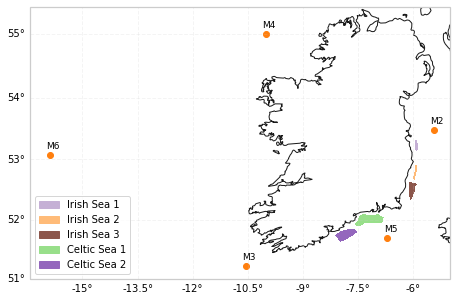

In [19]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.GOOGLE_MERCATOR))
plot_aois_ireland(ax=ax)

------------------------------------------------
## AOI Wind Data Assessment

This section demonstrates AOI assessment using 10m wind data provided by all EOOffshore Zarr stores, for the IWB and wind farm coordinates, including:
1. Mean 10m wind speed
1. AOI wind speed summary
1. Wind speed time series
1. Wind direction (wind roses)

----------------------------------------------------------------
### An initial look at 10m wind speed

#### Mean 10m wind speed for all data sets

Using Dask, the data set loading process is lazy, where no data is loaded inititally. Instead, data loading is [delayed until execution time, where variables will be loaded and processed in parallel according to the corresponding chunks specification](https://tutorial.dask.org/01x_lazy.html). Dask arrays implement a subset of the NumPy [`ndarray`](https://numpy.org/doc/stable/reference/arrays.ndarray.html) interface using blocked algorithms, and the original variable arrays will be split into smaller chunk arrays, enabling computation on arrays larger than memory using all available cores. The blocked algorithms are coordinated using [Dask graphs](https://docs.dask.org/en/stable/graphs.html).

Here, mean 10m wind speed (provided by all data sets) over the `time` dimension is computed for all grid coordinates in each data set, where Dask graph execution is triggered by calling [`compute()`](https://docs.dask.org/en/stable/api.html#dask.compute). The resulting variable values will be contained in a NumPy `ndarray`.

Graph execution is managed by a [task scheduler](https://docs.dask.org/en/stable/scheduling.html). The default scheduler (used for executing this notebook) executes computations with [local threads](https://docs.dask.org/en/stable/scheduling.html#local-threads). However, execution may also be performed on a [distributed cluster](https://docs.dask.org/en/stable/scheduling.html#dask-distributed-local) **without any change to the `xarray` code used here**.

**It is important to note here how the combination of the xarray, Dask, and Zarr libraries results in a scalable solution that can be applied to data sets of arbitrary sizes (related to heterogeneous spatial and temporal resolutions), as is the case with the EOOffshore catalog wind data sets. Parallel, out-of-core, computation of underlying variable chunks is achievable with identical calls to the xarray API.**

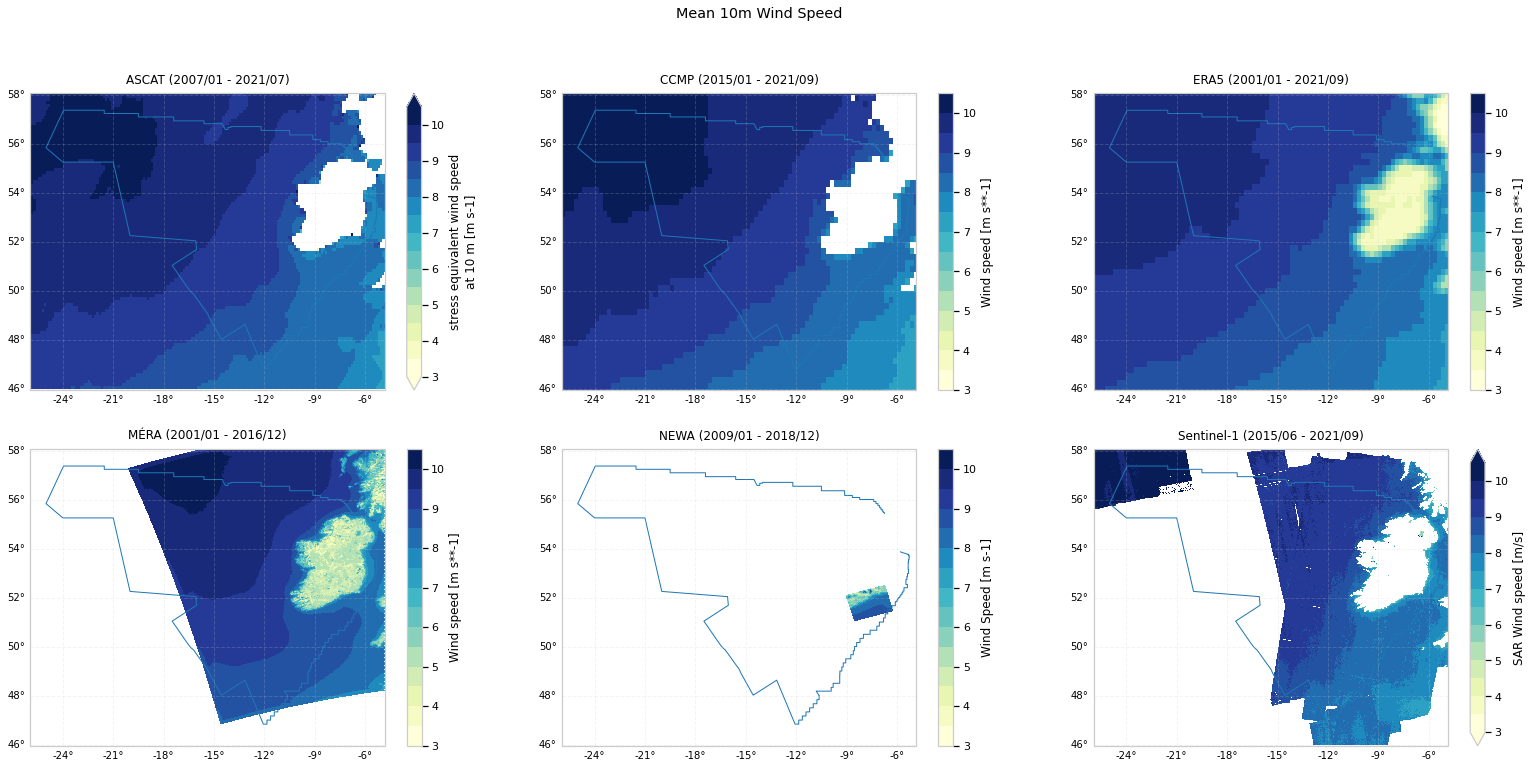

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(27, 12), subplot_kw=dict(projection=MAP_PROJECTION))
ax = ax.flatten()
for i, eooffshoreds in enumerate(PLOT_ICS_DATASETS):
    plot_ics_variable(variable=eooffshoreds.dataset.wind_speed.sel(height=10).mean(dim='time', keep_attrs=True).compute(),
                      title=f'{eooffshoreds.name} ({format_plot_time(eooffshoreds.dataset.time.min())} - {format_plot_time(eooffshoreds.dataset.time.max())})',
                      vmin=CUT_IN_WIND_SPEED,
                      vmax=10.5,
                      ax=ax[i],
                     )

fig.suptitle('Mean 10m Wind Speed');

------------------------------------------------
#### Mean seasonal 10m wind speed

If required, seasonal wind speed may be calculated using [`xarray.DataArray.groupby()`](https://docs.xarray.dev/en/stable/examples/monthly-means.html) with the `Season` (`time.season`) dimension (created during `EooffshoreDataset` initialisation). This is demonstrated using the MÉRA dataset.
* MAM = March, April, May
* JJA = June, July, August
* SON = September, October, November
* DJF = December, January, February

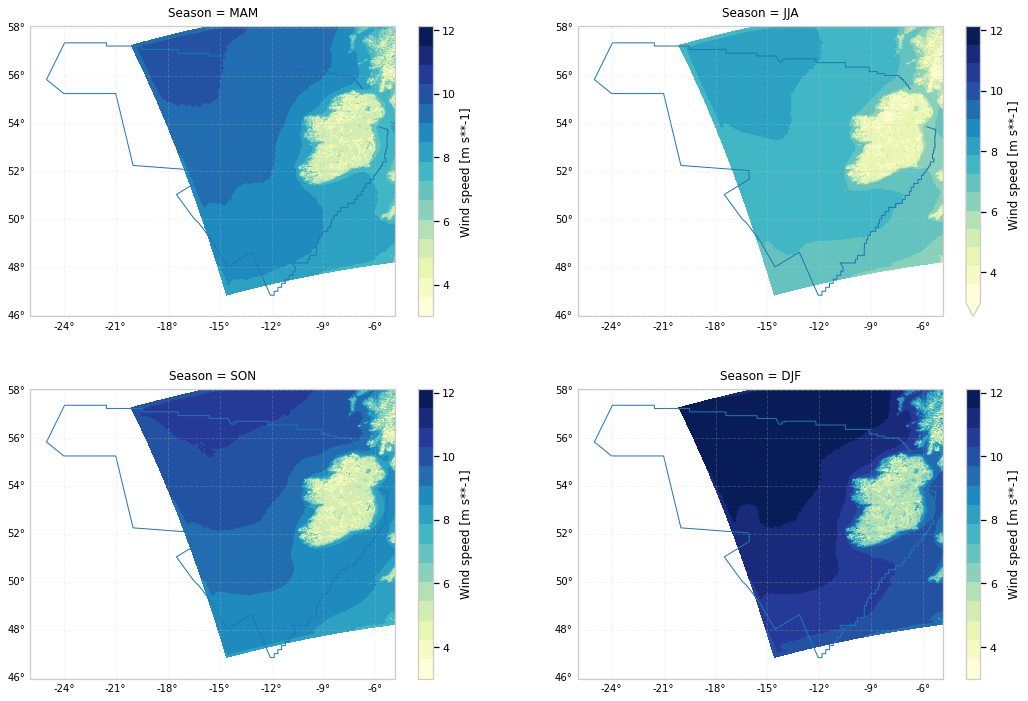

In [21]:
season_order = ['MAM', 'JJA', 'SON', 'DJF']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), subplot_kw=dict(projection=MAP_PROJECTION))
axes = ax.flatten()
seasonws = mera.dataset.wind_speed.sel(height=10).groupby('Season').mean(keep_attrs=True).compute()
for i, season in enumerate(season_order):
    ax = axes[i]
    plot_ics_variable(ax=ax,
                      variable=seasonws.sel(Season=season), 
                      title=f'Season = {season}',
                      vmin=CUT_IN_WIND_SPEED,
                      vmax=seasonws.max().item())
    plt.subplots_adjust(hspace=0.25)

----------------------------------------------------------------
### Wind speed summary

Here are utility functions used for AOI analysis:

1. Mean variable summary for provided data sets
1. Plotting variables over time:
   * Mean monthly values for provided datasets time period
   * Mean value per month of year

For wind farm AOIs, data is selected using the nearest lat/lon coordinates according to the regionmask-based mask (see `WindfarmEooffshoreDataset` above). Spatial mean values are used to represent individual wind farms, i.e. the mean value of all grid coordinates in the wind farm AOI. 

In [22]:
def aoi_summary(datasets: List[xr.Dataset], variable: str, height: int):
    """For all AOIs and specified datasets, calculate mean specified variable/height over time"""

    def variable_mean(aoids: xr.Dataset):
        mean = None
        if aoids:
            mean = aoids[variable].sel(height=height)
            mean = mean.mean(dim='time') if 'time' in mean.dims else mean
            mean = mean.values[0]
        return mean
    
    all_aoids = [{dataset.name: variable_mean(iwb.buoy_dataset(buoy, dataset)) for dataset in datasets} for buoy in iwb.buoys]
    all_aoids += [{dataset.name: variable_mean(eoowindfarmds.windfarm_dataset(windfarm, dataset, spatial_mean=True)) for dataset in datasets} for windfarm in eoowindfarmds.windfarms]
    return pd.DataFrame(all_aoids, index=iwb.buoys + eoowindfarmds.windfarms)

def plot_aoi_summary(aoi: str, aoi_datasets: List[xr.Dataset], variable: str, height: int):
    """AOI plots using the specified data sets"""    
    # Remove any duplicate times prior to concatenation
    aoi_variable = xr.concat([ds[variable].sel(height=height, time=~ds.get_index('time').duplicated()) for ds in aoi_datasets], 
                              dim='Dataset',
                              compat='no_conflicts') # Supports differences in time dimension chunking of underlying Dask arrays

    # Use ERA5 long name and units attributes
    variable_name = era5.dataset[aoi_variable.name].long_name
    title=f"{aoi_variable.height.item():.0f}m {variable_name.title().replace('_', ' ')}"
    
    def update_ax(axp, title, x_label):
        axp.set_title(f'{aoi} {title}')
        axp.set_xlabel(x_label)
        # Use ERA5 long name and units attributes
        axp.set_ylabel(f'{variable_name} [{era5.dataset[aoi_variable.name].units}]')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5.5))
    plt.subplots_adjust(wspace=0.2) 
    ax = ax.flatten()

    aoi_variable.resample(time='M').mean().plot(hue='Dataset', ax=ax[0]);
    update_ax(ax[0], f'{title} (Monthly Mean)', 'Time') 

    aoi_variable.groupby('time.month').mean().plot(hue='Dataset', ax=ax[1]);
    update_ax(ax[1], f'Mean {title} (Month of Year)', 'Month')

#### Total 10m wind speed observations/values

For the Zarr stores, this is computed with [`xarray.DataArray.count()`](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.count.html) along the `time` dimension

In [23]:
count_observations = lambda ds: ds.wind_speed.sel(height=10).count(dim='time').compute().item() if ds else 0

aoi_counts = [{dataset.name: count_observations(iwb.buoy_dataset(buoy, dataset)) for dataset in DATASETS} for buoy in iwb.buoys]
aoi_counts += [{dataset.name: count_observations(eoowindfarmds.windfarm_dataset(windfarm, dataset, spatial_mean=True)) for dataset in DATASETS} for windfarm in eoowindfarmds.windfarms]

pd.DataFrame(aoi_counts, index=iwb.buoys + eoowindfarmds.windfarms).style.format('{:,.0f}')

#### Mean 10m wind speed ($ms^{-1}$)

`nan` values indicate no data was found for a particular AOI (see mean map plots above)

In [24]:
aoi_summary(datasets=DATASETS, variable='wind_speed', height=10).style.format('{:.2f}')

--------------------------------------------
### Wind speed time series

---------------------------------
#### 10m wind speed since 2001 for IWB buoys
Using the M2 buoy as an example IWB AOI, the following plots are generated
* Time series of monthly mean wind speed
* Mean wind speed for each month, highlighting seasonal differences for an AOI.

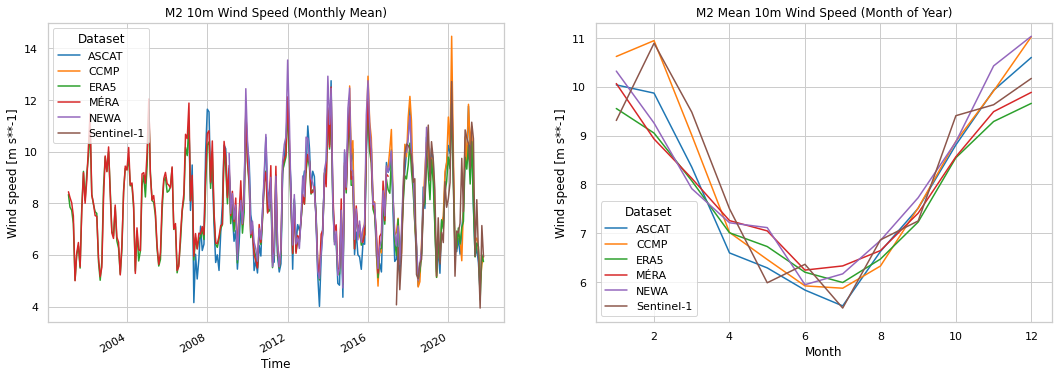

In [25]:
def plot_buoy_aoi_summary(buoy: str, datasets: List[xr.Dataset], variable: str, height: int):
    """IWB buoy AOI plots using the specified data sets"""
    plot_aoi_summary(aoi=buoy, 
                     aoi_datasets=[iwb.buoy_dataset(buoy, d) for d in datasets],
                     variable=variable,
                     height=height)
    
plot_buoy_aoi_summary(buoy='M2', datasets=DATASETS, variable='wind_speed', height=10)

---------------------------------
#### 10m wind speed since 2001 for wind farms

Similar time series plots for wind farm AOIs are generated here, using the Celtic Sea 1 wind farm as an example AOI
* Each mean wind speed is calculated as the corresponding spatial mean across the wind farm grid coordinates

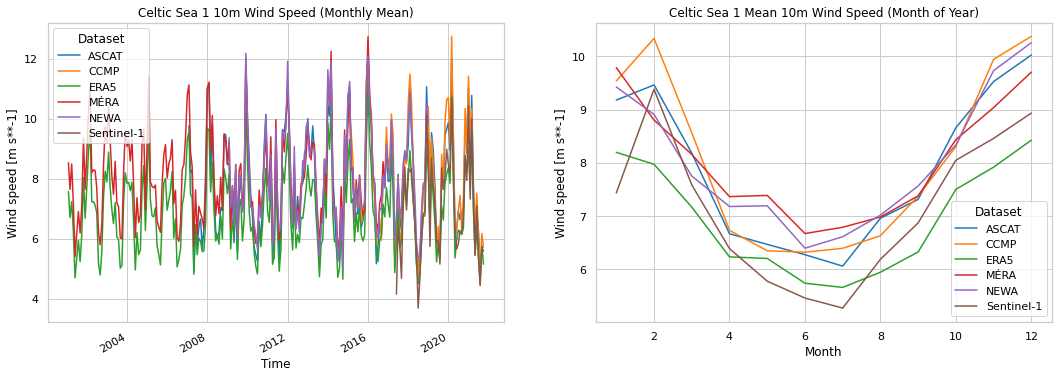

In [26]:
def plot_windfarm_aoi_summary(windfarm: str, datasets: List[xr.Dataset], variable: str, height: int):
    """Wind farm AOI plots using the specified data sets"""
    plot_aoi_summary(aoi=windfarm, 
                     aoi_datasets=[eoowindfarmds.windfarm_dataset(windfarm, d, spatial_mean=True) for d in datasets],
                     variable=variable,
                     height=height)
    
plot_windfarm_aoi_summary(windfarm='Celtic Sea 1', datasets=DATASETS, variable='wind_speed', height=10)

---------------------------------
### Wind direction

Wind direction is typically used to generate wind rose plots, which visualise wind speed distributions in direction sectors. Here, the [windrose library](https://windrose.readthedocs.io/en/latest/index.html) is used to create AOI plots for 30 degree direction sectors, each containing stacked wind speed histograms.

In [27]:
# The windrose projection doesn't render bars correctly unless at least one polar projection plot has been created
# For now, this placeholder appears to be sufficient for subsequent correct rendering
N = 1
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)
ax = plt.subplot(111, projection='polar')
bars = ax.bar(theta, radii, width=width, bottom=0.0)
plt.close()
# <end placeholder>

def plot_aoi_windrose(aoi: str, aoi_datasets: List[xr.Dataset], height: int):
    """Create an AOI wind rose plot for the specified data sets"""
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), subplot_kw=dict(projection="windrose", rmax=25))

    plt.subplots_adjust(wspace=0.1, hspace=0.3) 
    axes = axes.flatten()

    bins = np.arange(0, 25, 5)
    
    for i, ds in enumerate(aoi_datasets):
        ds = ds.sel(height=height)
        ax = axes[i]
        ax.bar(direction=ds.wind_direction.values.reshape(-1,), 
               var=ds.wind_speed.values.reshape(-1,), 
               nsector=12, 
               bins=bins, 
               normed=True, 
               opening=0.8, 
               edgecolor='white',
               cmap=plt.cm.YlGnBu)
        ax.set_legend(decimal_places=0, title=era5.dataset.wind_speed.units, title_fontsize='small', loc='lower right')
        labels = ax.get_legend().get_texts()
        for i in range(0, len(bins)-1):
            labels[i].set_text(f'{bins[i]} - {bins[i+1]}')
        labels[-1].set_text(f'{bins[-1]}+')                   
        ax.set_title(f'{ds.Dataset.item()}');
    fig.suptitle(f'{aoi} {height}m wind roses');

---------------------------------
#### 10m wind roses for IWB buoys
Using the M2 buoy as an example IWB AOI

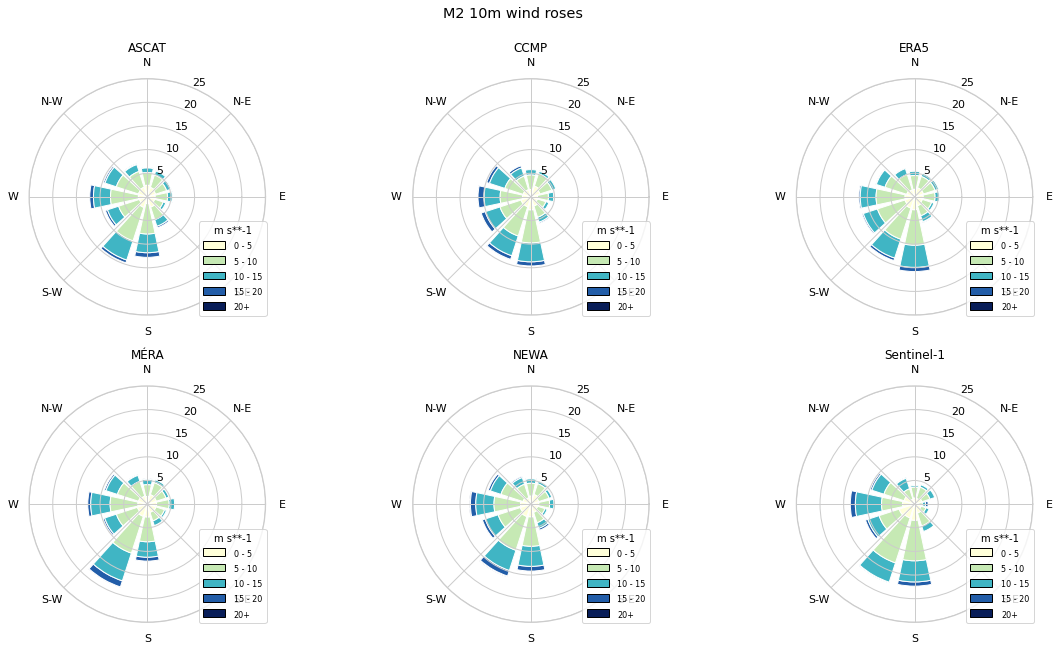

In [28]:
def plot_buoy_windroses(buoy: str, height: int):
    plot_aoi_windrose(aoi=buoy, aoi_datasets=[iwb.buoy_dataset(buoy, d) for d in DATASETS], height=height)

plot_buoy_windroses(buoy='M2', height=10)

---------------------------------
#### 10m wind roses for wind farms
Using the Celtic Sea 1 wind farm as an example AOI

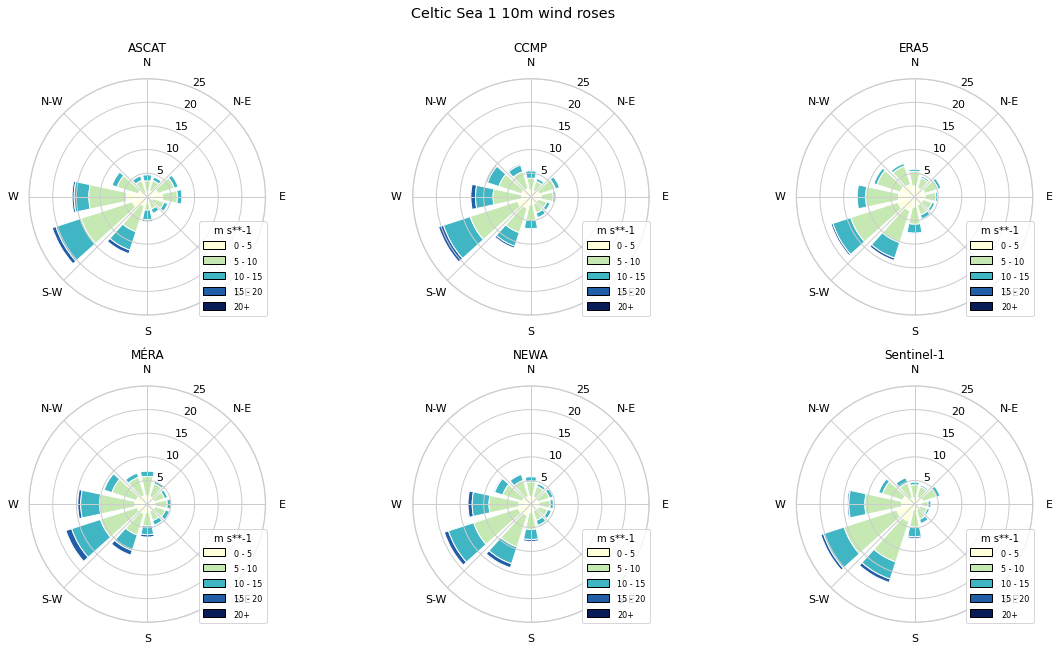

In [29]:
def plot_windfarm_windroses(buoy: str, height: int):
    plot_aoi_windrose(aoi=buoy, aoi_datasets=[eoowindfarmds.windfarm_dataset(buoy, d) for d in DATASETS], height=height)

plot_windfarm_windroses(buoy='Celtic Sea 1', height=10)

----------------------------------------------
## Wind Speed Extrapolation

Wind speed extrapolation is the process of extrapolating data values at provided heights to one or more required heights for which data is unavailable, generating a wind speed profile at an AOI. For satellite or reanalysis, data is usually restricted to values at 10m above the surface level. Consequently, extrapolation may be used with these 10m data to generate wind speed values at typical [wind turbine hub heights](https://www.wind-energy-the-facts.org/hub-height.html). The following publications provide examples of wind speed extrapolation:

* [Badger et al. (2016) - Extrapolating Satellite Winds to Turbine Operating Heights](https://doi.org/10.1175/JAMC-D-15-0197.1)
* [Shu et al. (2016) - Observations of offshore wind characteristics by Doppler-LiDAR for wind energy applications](https://doi.org/10.1016/j.apenergy.2016.01.135)
* [Carvalho et al. (2017) - Offshore winds and wind energy production estimates derived from ASCAT, OSCAT, numerical
weather prediction models and buoys – A comparative study for the Iberian Peninsula Atlantic coast](https://doi.org/10.1016/j.renene.2016.10.063)
* [Karagali et al. (2018) - New European wind atlas offshore](https://iopscience.iop.org/article/10.1088/1742-6596/1037/5/052007)
* [Remmers et al. (2019) - The Potential of Advanced Scatterometer (ASCAT) 12.5 km Coastal Observations for Offshore Wind Farm Site Selection in Irish Waters](https://doi.org/10.3390/en12020206)
* [de Montera et al. (2020) - Validation of Sentinel-1 offshore winds and average wind power estimation around Ireland](https://doi.org/10.5194/wes-5-1023-2020)
* [Schelbergen et al. (2020) - Clustering wind profile shapes to estimate airborne wind energy production](https://doi.org/10.5194/wes-5-1097-2020)
* [Xu et al. (2020) - Proliferation of offshore wind farms in the North Sea and surrounding waters revealed by satellite image time series](https://doi.org/10.1016/j.rser.2020.110167)

This section is not intended to be a complete analysis of possible extrapolation methods. Instead, its objective is to demonstrate how it may be implemented using the scalable approach offered by the combination of the xarray, Dask and Zarr libraries.

### Power law extrapolation

The [Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation](./Comparison_Wind_Power.ipynb) notebook demonstrates the comparison of wind speed extrapolation methods using the EOOffshore catalog, where the associated metrics have identified the power law method as suitable for extrapolating 10m wind speed to hub heights. This approach has also been used in previous analysis, (for example, [Remmers et al., 2019](https://doi.org/10.3390/en12020206); [Schelbergen et al., 2020](https://doi.org/10.5194/wes-5-1097-2020)). It is defined as follows ([Hsu et al., 1994 - Determining the Power-Law Wind-Profile Exponent under Near-Neutral Stability Conditions at Sea](https://journals.ametsoc.org/view/journals/apme/33/6/1520-0450_1994_033_0757_dtplwp_2_0_co_2.xml)):

$u = u_r\left(\dfrac{z}{z_r}\right)^\alpha$

* $u$: wind speed ($m s^{-1}$) at required height $z$ ($m$) 
* $z_r$: reference height (e.g. 10m for data provided by ERA5, Sentinel-1 etc.)
* $u_r$: wind speed at $z_r$
* $\alpha$: function of atmospheric stability and surface characteristics

Here are some utility classes providing an implementation of power law extrapolation that will operate on the EOOffshore Zarr stores.

In [30]:
class Extrapolator(ABC):
    """Base Extrapolator class"""
    
    @abstractmethod
    def extrapolate(self, ds: xr.Dataset, variable_name: str, heights: list[int]):
        """Extrapolate data set variable to required heights"""
        pass
    
    def _add_extrapolated_variable(self, ds: xr.Dataset, variable_name: str, extrapolated: dict, reindex_height: bool, variable_attrs: dict={}) -> xr.Dataset: 
        """Adds extrapolated values to existing variable, at height, and returns an updated Dataset"""
        height_attrs = ds.height.attrs
        ea = xr.concat([vda.assign_coords(height=height).expand_dims(['height']) for height, vda in extrapolated.items()], dim='height').sortby('height')
        if reindex_height:
            ds = ds.reindex({'height': ea.height}).chunk({'height':1})
        ds[variable_name] = ea
        # Height attributes are overwritten, restore them now
        ds.height.attrs.update(height_attrs)
        
        if variable_attrs:
            ds[variable_name].attrs.update(variable_attrs)
            
        return ds
    
class WindSpeedExtrapolator(Extrapolator):
    """Base wind speed Extrapolator class"""
    
    def extrapolate(self, ds: xr.Dataset, heights: list[int], variable_name: str = 'wind_speed'):
        """Extrapolate wind speed to required heights"""
        
        # Retain pre-existing height if required
        extrapolated_wind_speed = {height: ds[variable_name].sel(height=height) for height in ds.height.values if height not in heights}

        # Extrapolate to other heights
        for height in [h for h in heights if h not in extrapolated_wind_speed]:
            extrapolated_wind_speed[height] = self._extrapolate_wind_speed(ds=ds, variable_name=variable_name, extrapolation_height=height, reference_height=10)
        
        # Reindex height dimension if required
        reindex_height = len([h for h in heights if h not in ds.height.values]) > 0
        return self._add_extrapolated_variable(ds, variable_name, extrapolated_wind_speed, reindex_height=reindex_height)
    
    @abstractmethod
    def _extrapolate_wind_speed(self, ds: xr.Dataset, variable_name, extrapolation_height: int, reference_height: int) -> xr.DataArray:
        """Wind speed extrapolation method implementation"""
        pass
    
@dataclass
class PowerLawWindSpeedExtrapolator(WindSpeedExtrapolator):
    """Wind speed Extrapolator implementation, using the power law method"""
    alpha: float = 0.11 # Hsu 1994

    def __init__(self, alpha: float=0.11):
        self.alpha = alpha
    
    def _extrapolate_wind_speed(self, ds: xr.Dataset, variable_name: str, extrapolation_height: int, reference_height: int) -> xr.DataArray:
        """Wind speed extrapolation method implementation"""
        return ds[variable_name].sel(height=reference_height) * (extrapolation_height/reference_height)**self.alpha

-------------------------------------
#### Power law $\alpha$ estimation

A value of $\alpha$ = 0.1 or 0.11 is often used as a good approximation for use at sea with the power law method ([Hsu et al., 1994](https://journals.ametsoc.org/view/journals/apme/33/6/1520-0450_1994_033_0757_dtplwp_2_0_co_2.xml)). However, metrics 
generated by the [Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation](./Comparison_Wind_Power.ipynb) notebook suggest that an alternative $\alpha$ value may be more suitable. The ERA5 data set provides wind speed at both 10m and 100m, which may be used to calculate $\alpha$ as follows:

$\alpha = \dfrac{\mathrm{ln}\left(\dfrac{u_2}{u_1}\right)}{\mathrm{ln}\left(\dfrac{z_2}{z_1}\right)}$

* $z_1$: height 1, e.g. 10m
* $z_2$: height 2, e.g. 100m
* $u_1$: wind speed ($m s^{-1}$) at height $z_1$, e.g. ERA5 10m wind speed
* $u_2$: wind speed ($m s^{-1}$) at height $z_2$, e.g. ERA5 100m wind speed

Here, the following are computed:
1. An ERA5 `powerlaw_alpha` variable, computed at each time for all grid coordinates. This will be used for extrapolating ERA5 10m wind speed to heights other than 100m.
1. A power law extrapolator with $\alpha$ = mean ERA5 `powerlaw_alpha`.

**Note:**
* **xarray provides implementations of certain [NumPy universal functions (ufunc)](https://numpy.org/doc/stable/reference/ufuncs.html), including [`xarray.ufuncs.log()`](https://xarray.pydata.org/en/stable/generated/xarray.ufuncs.log.html) as used to calculate $\alpha$. Using ufuncs ensures that lazy computation applies, i.e. the corresponding Dask graph execution does not occur until `compute()` is called.**

In [31]:
era5.dataset['powerlaw_alpha'] = (xr.ufuncs.log(era5.dataset.wind_speed.sel(height=100)/era5.dataset.wind_speed.sel(height=10))/math.log(100/10))
mean_era5_alpha_powerlaw_extrapolator = PowerLawWindSpeedExtrapolator(alpha=era5.dataset.powerlaw_alpha.mean().compute().item())

--------------------------------
#### Extrapolation to required hub heights

The required hub heights are those featured in the [Sustainable Energy Authority of Ireland (SEAI)](https://www.seai.ie/) 2013 wind atlas ([UK Met Office, 2015 - Remodelling the Irish national onshore and offshore wind atlas](https://www.metoffice.gov.uk/binaries/content/assets/mohippo/pdf/0/8/frtr_591_2015.pdf)). Power law $\alpha$ values are motivated by the findings in the [Comparison of Offshore Wind Speed Extrapolation and Power Density Estimation](./Comparison_Wind_Power.ipynb) notebook. No extrapolation is performed for MÉRA and NEWA as they provide data at multiple heights.

In [32]:
hub_heights = [20, 30, 40, 50, 75, 100, 125, 150]

ascat.dataset = mean_era5_alpha_powerlaw_extrapolator.extrapolate(ds=ascat.dataset, heights=hub_heights)
ccmp.dataset = mean_era5_alpha_powerlaw_extrapolator.extrapolate(ds=ccmp.dataset, heights=hub_heights)
era5.dataset = PowerLawWindSpeedExtrapolator(alpha=era5.dataset.powerlaw_alpha).extrapolate(ds=era5.dataset, heights=hub_heights)
sentinel1.dataset = PowerLawWindSpeedExtrapolator().extrapolate(ds=sentinel1.dataset, heights=hub_heights)

---------------------------------
### AOI wind profiles

Wind profile plots are used to visualise mean wind speed at multiple heights for an AOI. Here, wind profiles are generated for each IWB buoy and wind farm AOI using the extrapolated or provided wind speeds.

Note:
* Wind farm mean wind speeds are calculated as the corresponding spatial mean across the wind farm grid coordinates
* The ASCAT wind profile for the Irish Sea 1 AOI appears to be an outlier. This is likely related to the low number of observations for this AOI (see above). ASCAT wind quality flags are described in the [ASCAT Wind Data for Irish Continental Shelf region](./ASCAT_ICS_Wind_Data.ipynb) notebook.

In [33]:
all_aoi_datasets = [(buoy, [iwb.buoy_dataset(buoy, d) for d in DATASETS]) for buoy in iwb.buoys]
all_aoi_datasets += [(windfarm, [eoowindfarmds.windfarm_dataset(windfarm, d, spatial_mean=True) for d in DATASETS]) for windfarm in eoowindfarmds.windfarms]

mean_windspeed_df = lambda aoids: aoids.wind_speed.mean(dim='time').to_dataframe().reset_index() if aoids else None
profiledf = None

for aoi, aoi_datasets in all_aoi_datasets:
    aoidf = pd.concat([mean_windspeed_df(d) for d in aoi_datasets])[['Dataset', 'height', 'wind_speed']]
    aoidf['AOI'] = aoi
    profiledf = pd.concat((profiledf, aoidf), ignore_index=True)

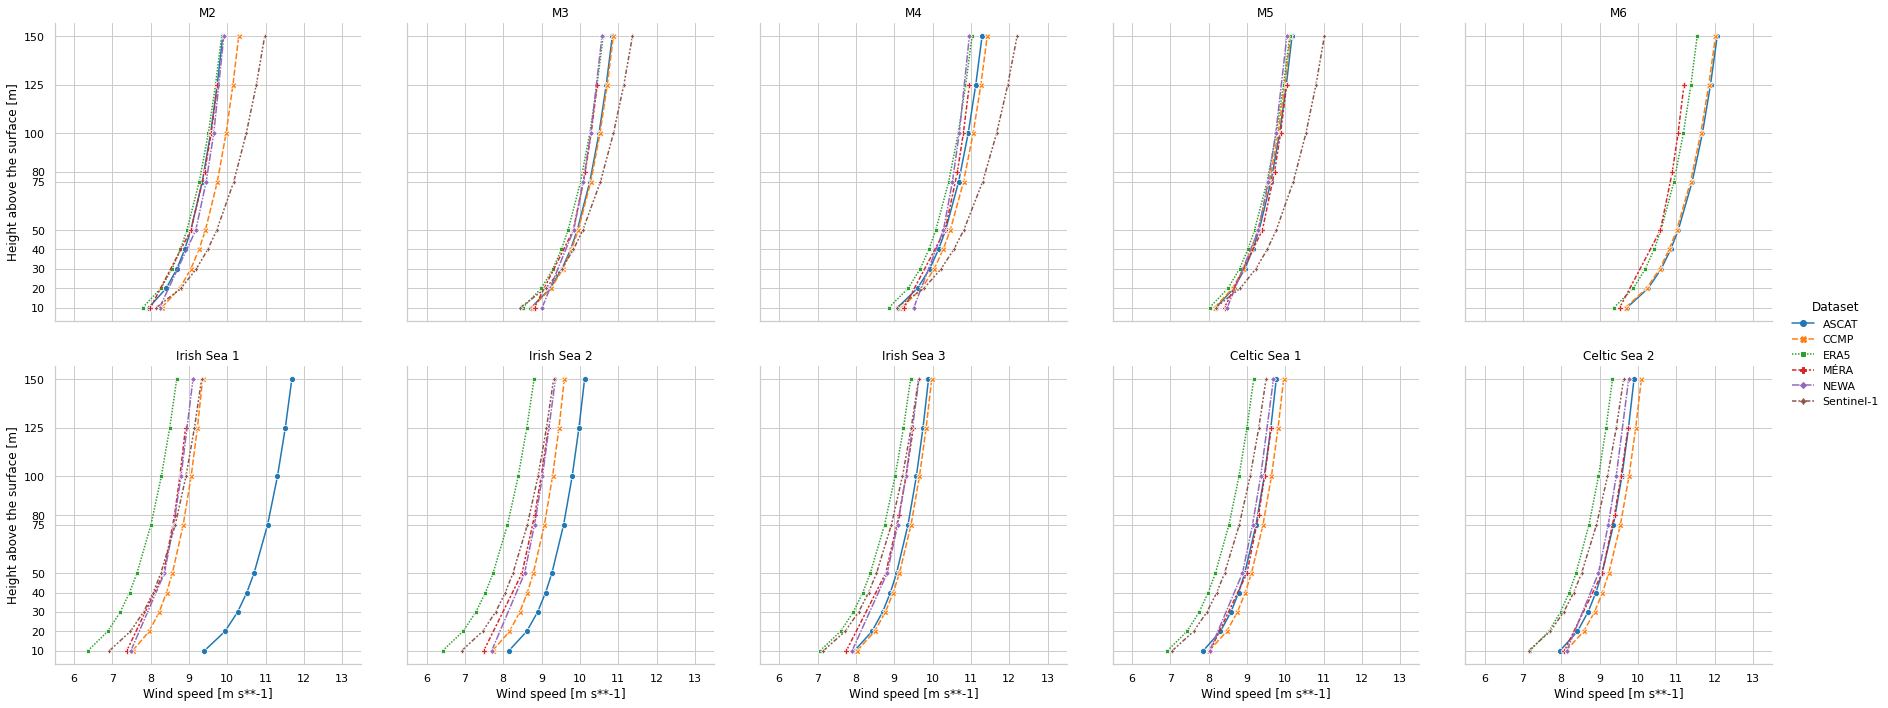

In [34]:
hue='Dataset'

g = sns.relplot(data=profiledf, 
                kind='line', 
                col='AOI', 
                col_wrap=5, 
                x='wind_speed', 
                y='height', 
                markers=True, 
                style=hue, 
                hue=hue, 
               )
(g.set(xlim=(5.5, 13.5), yticks=profiledf.height.unique()) 
  .set_titles('{col_name}')
  .set_xlabels(f'{era5.dataset.wind_speed.long_name} [{era5.dataset.wind_speed.units}]')
  .set_ylabels(f'{era5.dataset.height.long_name} [{era5.dataset.height.units}]')
)
g.fig.subplots_adjust(hspace=0.15, wspace=0.15)

--------------------------------------------------------
## Power Density Estimation

Offshore wind power density estimates may be generated for an AOI using the available wind speed values at the corresponding coordinates. When used in combination with wind speed extrapolation as described above, it is possible to estimate power at typical wind turbine hub heights. The following publications provide examples of power density estimation using wind speed:

* [Pryor et al. (2004) - Can Satellite Sampling of Offshore Wind Speeds Realistically Represent Wind Speed Distributions? Part II: Quantifying Uncertainties Associated with Distribution Fitting Methods](https://doi.org/10.1175/2096.1)
* [Doubrawa et al. (2015) - Satellite winds as a tool for offshore wind resource assessment: The Great Lakes Wind Atlas](https://doi.org/10.1016/j.rse.2015.07.008)
* [Hasager et al. (2015) - Offshore wind climatology based on synergetic use of Envisat ASAR, ASCAT and QuikSCAT](https://doi.org/10.1016/j.rse.2014.09.030)
* [Badger et al. (2016) - Extrapolating Satellite Winds to Turbine Operating Heights](https://doi.org/10.1175/JAMC-D-15-0197.1)
* [Shu et al. (2016) - Observations of offshore wind characteristics by Doppler-LiDAR for wind energy applications](https://doi.org/10.1016/j.apenergy.2016.01.135)
* [Remmers et al. (2019) - The Potential of Advanced Scatterometer (ASCAT) 12.5 km Coastal Observations for Offshore Wind Farm Site Selection in Irish Waters](https://doi.org/10.3390/en12020206)
* [Ahsbahs et al. (2020) - US East Coast synthetic aperture radar wind atlas for offshore wind energy](https://doi.org/10.5194/wes-5-1191-2020)
* [de Montera et al. (2020) - Validation of Sentinel-1 offshore winds and average wind power estimation around Ireland](https://doi.org/10.5194/wes-5-1023-2020)
* [Xu et al. (2020) - Proliferation of offshore wind farms in the North Sea and surrounding waters revealed by satellite image time series](https://doi.org/10.1016/j.rser.2020.110167)

-----------------------------------------
### AOI wind speed distributions and Weibull parameters

AOI wind speed is typically represented by a Weibull distribution of observations, characterized by a shape parameter ($k$, dimensionless) and a scale parameter ($\lambda$, $m s^{-1}$) ([Ahsbahs et al., 2020](https://doi.org/10.5194/wes-5-1191-2020)). The Weibull probability density function (PDF) is as follows:

$\mathrm{PDF}(U) = \dfrac{k}{\lambda}\left(\dfrac{U}{k} \right)^{k-1} \epsilon^{-(U/\lambda)^k}$

A minimum number of observations or samples are required for Weibull parameter fitting, this is relevant for SAR data such as the [Sentinel-1 data set](./Sentinel-1_ICS_Wind_Data.ipynb). Consequently, wind speeds from all directional sectors have been used for fitting ([Badger et al., 2016](https://doi.org/10.1175/JAMC-D-15-0197.1)), where the same process is applied in this notebook to each EOOffshore data set. 

Here are some utility functions that plot AOI wind speed distributions and corresponding Weibull PDFS for all data sets, where the Weibull parameters have been fit using [`scipy.stats.weibull_min()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html).

In [35]:
def weibull_fit(data: np.array):
    """Fit Weibull parameters using scipy"""
    # Known issues with `loc` parameter: https://github.com/scipy/scipy/issues/11806
    for loc in [1, 0]:
        shape, loc, scale = weibull_min.fit(data, loc=loc)
        # Occasionally, loc=1 results in an inaccurate fit: 
        # Try other loc=x appears to generate an appropriate fit
        if shape > 1.85 and shape < 10:
            break
    return shape, loc, scale

def plot_aoi_weibull(aoi: str, aoi_datasets: List[xr.Dataset], height: int):
    """Plot AOI Weibull fits and wind speed distributions for specified data sets"""
    windspeed_df = pd.concat([d.wind_speed.sel(height=height).to_dataframe().reset_index() if d else None for d in aoi_datasets], ignore_index=True)[['Dataset', 'wind_speed']].dropna()

    # Don't want to share y-axis in FacetGrid as there can be differences in number of observations per dataset
    g = sns.displot(windspeed_df, x='wind_speed', stat='density', hue='Dataset', col='Dataset', col_wrap=3, legend=False, facet_kws=dict(sharey=False))

    dataset_proportions = (windspeed_df.groupby('Dataset').size() / len(windspeed_df)).to_dict()
    for i, dataset in enumerate(windspeed_df.Dataset.unique()):
        dataset_windspeed = windspeed_df[windspeed_df.Dataset==dataset].wind_speed.values
        shape, loc, scale = weibull_fit(dataset_windspeed)
        sorted_windspeed = sorted(dataset_windspeed)
        ax = g.axes[i]
        ax.plot(sorted_windspeed, weibull_min.pdf(sorted_windspeed, shape, loc, scale) * dataset_proportions[dataset], 'r-', lw=2, alpha=0.6)
        ax.set_title(f'{dataset} ($k$ = {shape:.2f}, $\lambda$ = {scale:.2f})')
        ax.set_xlabel(f'{era5.dataset.wind_speed.long_name} [{era5.dataset.wind_speed.units}]')
        ax.legend(['Weibull fit', dataset])
        
def plot_buoy_weibull(buoy: str, height: int):
    """Plot IWB buoy AOI Weibull fits and wind speed distributions"""
    plot_aoi_weibull(aoi=buoy, aoi_datasets=[iwb.buoy_dataset(buoy, d) for d in DATASETS], height=height)

def plot_windfarm_weibull(windfarm: str, height: int):
    """Plot wind farm AOI Weibull fits and wind speed distributions"""
    # Spatial mean wind speed is used for MÉRA and NEWA to reduce computation prior to Weibull fit
    datasets = [(ascat, False), 
                (ccmp, False),
                (era5, False),
                (mera, True),
                (newa, True),
                (sentinel1, False)
               ]
    plot_aoi_weibull(aoi=windfarm, aoi_datasets=[eoowindfarmds.windfarm_dataset(windfarm, d, spatial_mean=spatial_mean) for d, spatial_mean in datasets], height=height)

---------------------------------
#### 10m wind speed distributions and Weibull parameters for IWB buoys
Using the M2 buoy as an example IWB AOI

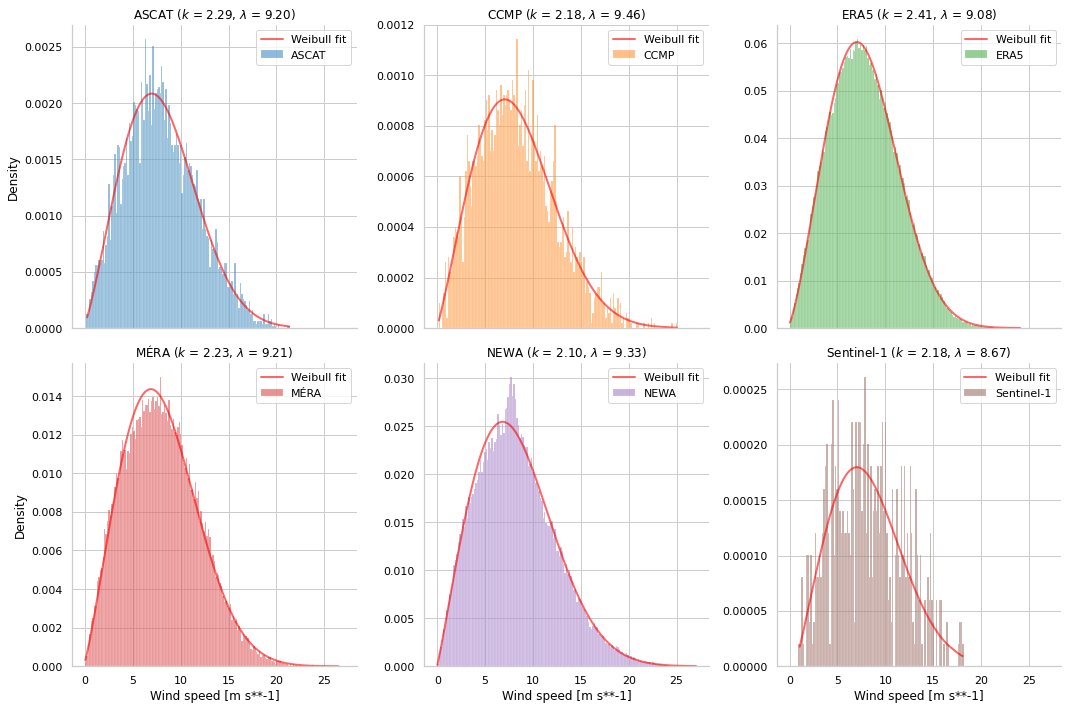

In [36]:
plot_buoy_weibull(buoy='M2', height=10)

---------------------------------
#### 10m wind speed distributions and Weibull parameters for wind farms
Using the Celtic Sea 1 wind farm as an example AOI

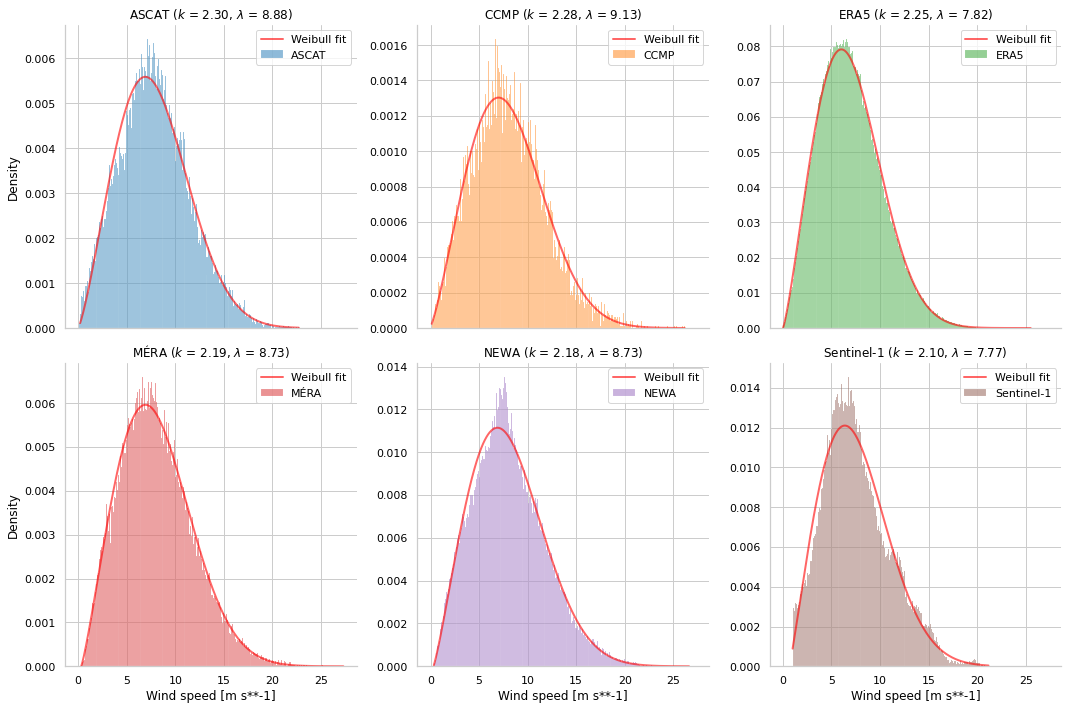

In [37]:
plot_windfarm_weibull(windfarm='Celtic Sea 1', height=10)

--------------------------------------
### Estimation implementation

Power density estimation at multiple heights is implemented as an `Extrapolator`, as used for wind speed extrapolation above. Here is the base class used for all implementations.

In [38]:
class PowerDensityEstimator(Extrapolator):
    """Base power density estimator class, implemented as an Extrapolator to reuse the creation of new variables with height dimension"""
    attrs: dict[str, str] = {
                            'long_name': 'Power density (estimate)',
                            'units': 'Wm**-2'
                            }
    min_wind_speed: float = CUT_IN_WIND_SPEED
    max_wind_speed: float = CUT_OUT_WIND_SPEED
    wind_speed_variable_name: str = 'wind_speed'

    def __init__(self, air_density: float=1.225):
        self.air_density = air_density

    def extrapolate(self, ds: xr.Dataset, heights: list[int], variable_name: str = 'power_density'):
        """Estimate power density at required heights"""        
        estimated_power_density = {height: self._estimate_power_density(wind_speed=self._filter_wind_speed(ds[self.wind_speed_variable_name].sel(height=height)))
                                           for height in heights}
        
        return self._add_extrapolated_variable(ds, variable_name, estimated_power_density, reindex_height=False, variable_attrs=self.attrs)

    def _filter_wind_speed(self, wind_speed: xr.DataArray):
        """Filters to turbine cut in/out range"""
        return wind_speed.where((wind_speed >= self.min_wind_speed) & (wind_speed <= self.max_wind_speed))
        
    @abstractmethod
    def _estimate_power_density(self, wind_speed: xr.DataArray) -> xr.DataArray:
        """Power density estimation implementation"""
        pass

### Weibull parameters for all coordinates

Mean wind power density is related to the corresponding Weibull parameters as follows ([Ahsbahs et al., 2020](https://doi.org/10.5194/wes-5-1191-2020)):

$P = \dfrac{1}{2}\rho \lambda^3 \Gamma \left(1 + \dfrac{3}{k}\right)$

* $P$: wind power density ($W m^{-2}$)
* $U$: wind speed ($m s^{-1}$)
* $\rho$: air density ($kg$ $m^{-3}$), a default value of 1.225 is typically used over oceans
* $\Gamma$: gamma function ([`scipy.special.gamma()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) is used in this notebook)
* $k$: Weibull shape parameter (dimensionless)
* $\lambda$: Weibull scale parameter ($m s^{-1}$)

Using the [`scipy.stats.weibull_min()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html) implementation for Weibull parameter fitting, as described above, is sufficient for individual AOI assessment. This approach does not scale well, preventing Weibull parameter fitting for all grid coordinates in data sets with high spatial resolutions. However, [Justus et al., 1976 (Methods for Estimating Wind Speed Frequency Distributions)](https://doi.org/10.1175/1520-0450(1978)017%3C0350:MFEWSF%3E2.0.CO;2) proposed parameter estimation as follows, which has been used with Sentinel-1 wind speed data ([de Montera et al., 2020](https://doi.org/10.5194/wes-5-1023-2020))

$k = \left(\dfrac{\sigma}{\mu} \right)^{-1.086}$ 

$\lambda = \dfrac{\mu}{\Gamma \left(\frac{1}{k} + 1 \right)}$

* $\mu$: mean wind speed ($m s^{-1}$)
* $\sigma$: wind speed standard deviation ($m s^{-1}$)

This approach can be implemented using xarray's lazy computation, where the corresponding Dask graph execution does not occur until `compute()` is called, and will scale to accomodate all data sets in the EOOffshore catalog.

In [39]:
class WeibullWindSpeedPowerDensityEstimator(PowerDensityEstimator):
    """Power density estimation using Weibull parameters"""

    def _filter_wind_speed(self, wind_speed: xr.DataArray):
        """Filters to turbine cut in/out range"""
        # No filtering is performed prior to Weibull parameter fitting
        return wind_speed

    def _estimate_power_density(self, wind_speed: xr.DataArray) -> xr.DataArray:
        """Power density estimation implementation"""
        shape, scale = self.fit_parameters(wind_speed)
        return 0.5 * self.air_density * (scale**3) * gamma(1+(3/shape))        

    def fit_parameters(self, wind_speed: xr.DataArray) -> Tuple[xr.DataArray, xr.DataArray]:
        """Fit Weibull parameters"""
        # As  used in de Montera et al., 2020
        mean_wind_speed = wind_speed.mean(dim='time')
        shape = (wind_speed.std(dim='time')/mean_wind_speed)**-1.086
        scale = mean_wind_speed / gamma((1/shape)+1)
        return shape, scale

Create Weibull shape and scale parameters for all data sets

In [40]:
weibull_power_estimator = WeibullWindSpeedPowerDensityEstimator()

for d in PLOT_ICS_DATASETS:
    weibull_shape, weibull_scale = weibull_power_estimator.fit_parameters(d.dataset.wind_speed)
    weibull_shape.attrs = {'units': 'dimensionless', 'long_name': 'Weibull shape (k)'}
    weibull_scale.attrs = {'units': d.dataset.wind_speed.units, 'long_name': 'Weibull scale ($\lambda$)'}
    d.dataset['weibull_shape'] = weibull_shape
    d.dataset['weibull_scale'] = weibull_scale

----------------------------------
#### 10m Weibull shape (k) parameter

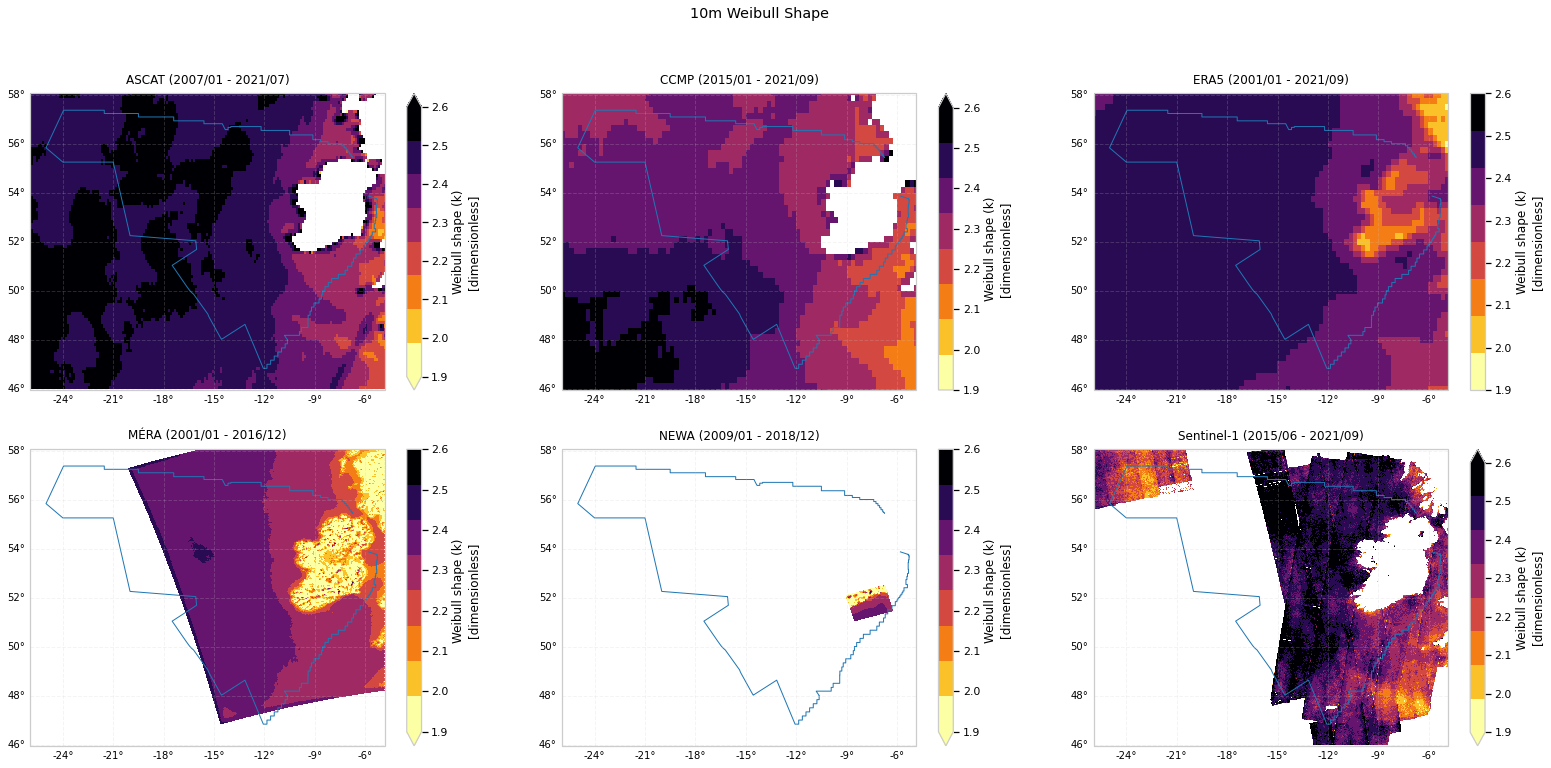

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(27, 12), subplot_kw=dict(projection=MAP_PROJECTION))
ax = ax.flatten()
for i, eooffshoreds in enumerate(PLOT_ICS_DATASETS):
    plot_ics_variable(variable=eooffshoreds.dataset.weibull_shape.sel(height=10).compute(),
                      title=f'{eooffshoreds.name} ({format_plot_time(eooffshoreds.dataset.time.min())} - {format_plot_time(eooffshoreds.dataset.time.max())})',
                      vmin=1.9,
                      vmax=2.6,
                      ax=ax[i],
                      cmap=plt.cm.get_cmap('inferno_r', 8)
                     )

fig.suptitle('10m Weibull Shape');

----------------------------------
#### 10m Weibull scale ($\lambda$) parameter

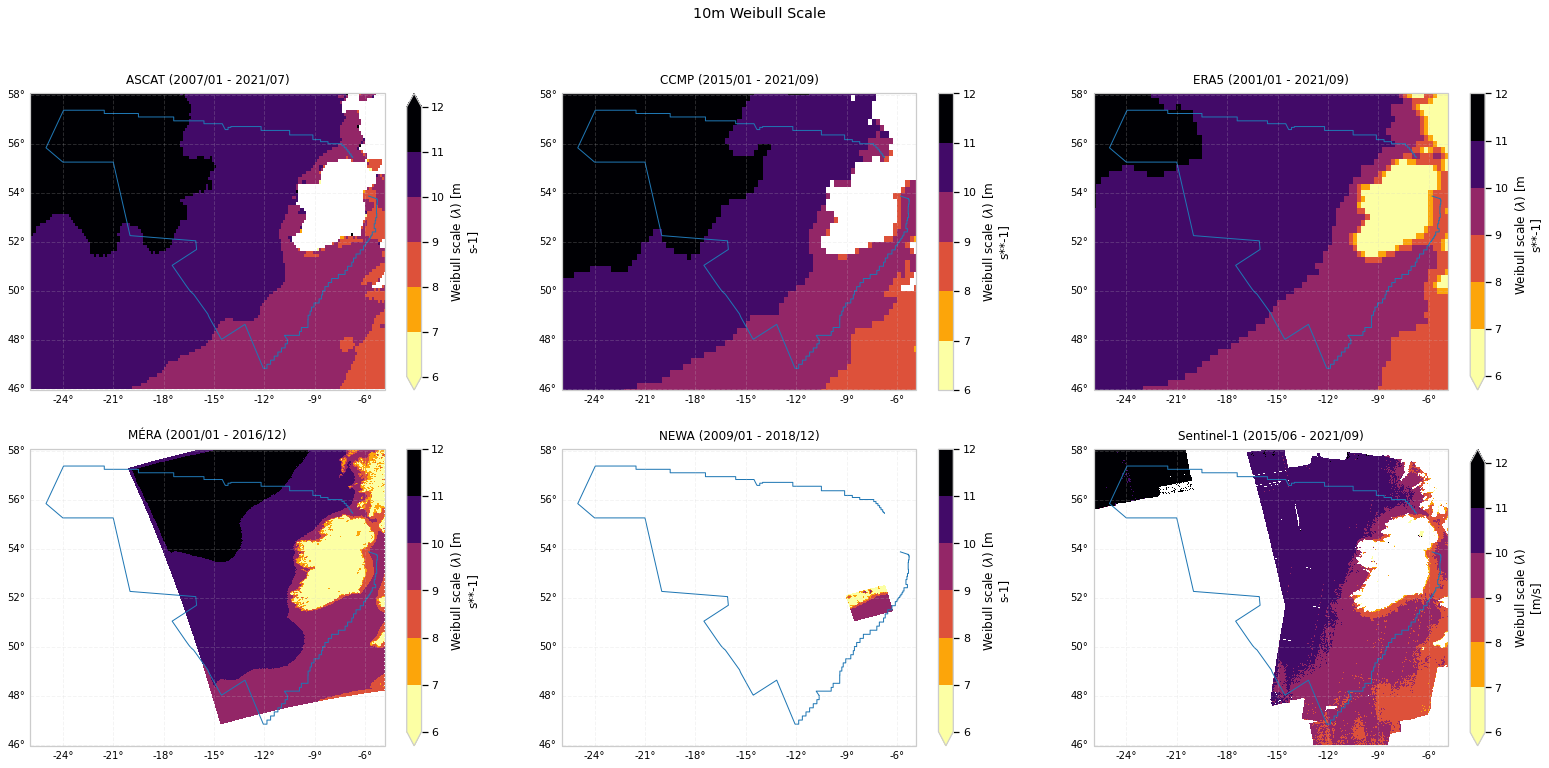

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(27, 12), subplot_kw=dict(projection=MAP_PROJECTION))
ax = ax.flatten()
for i, eooffshoreds in enumerate(PLOT_ICS_DATASETS):
    plot_ics_variable(variable=eooffshoreds.dataset.weibull_scale.sel(height=10).compute(),
                      title=f'{eooffshoreds.name} ({format_plot_time(eooffshoreds.dataset.time.min())} - {format_plot_time(eooffshoreds.dataset.time.max())})',
                      vmin=6,
                      vmax=12,
                      ax=ax[i],
                      cmap=plt.cm.get_cmap('inferno_r', 6)
                     )

fig.suptitle('10m Weibull Scale');

--------------------------
### Power density estimation using cubed wind speed

When a data set provides a complete time series of wind speed observations, power density may be estimated from the cube of the wind speed ([de Montera et al., 2020](https://doi.org/10.5194/wes-5-1023-2020)):

$P = \dfrac{1}{2}\rho U^3$

* $P$: wind power  density ($W m^{-2}$)
* $\rho$: air density ($kg$ $m^{-3}$), a default value of 1.225 is typically used over oceans
* $U$: wind speed ($m s^{-1}$)

In [43]:
class CubedWindSpeedPowerDensityEstimator(PowerDensityEstimator):
    """Power density estimation using complete wind speed time series"""

    def _estimate_power_density(self, wind_speed: xr.DataArray) -> xr.DataArray:
        """Power density estimation implementation"""
        return 0.5 * self.air_density * (wind_speed**3)

--------------------------------
### Estimation at required hub heights

Similar to extrapolation above, power density is estimated at required hub heights for all EOOffshore catalog data sets.
* The wind time series cube method is used for all data sets apart from Sentinel-1. As the latter does not provide a complete observation time series, the Weibull method is used instead. 
* No estimation is performed for NEWA as it provides power data at multiple heights.

In [44]:
cubed_windspeed_estimator = CubedWindSpeedPowerDensityEstimator()
weibull_power_estimator = WeibullWindSpeedPowerDensityEstimator()

for d, estimator in [(ascat, cubed_windspeed_estimator), 
                     (ccmp, cubed_windspeed_estimator),
                     (era5, cubed_windspeed_estimator),
                     (mera, cubed_windspeed_estimator),
                     (sentinel1, weibull_power_estimator),
                    ]:
    d.dataset = estimator.extrapolate(ds=d.dataset, heights=d.dataset.height.values)

----------------------------------------
#### 100m power density for all data sets

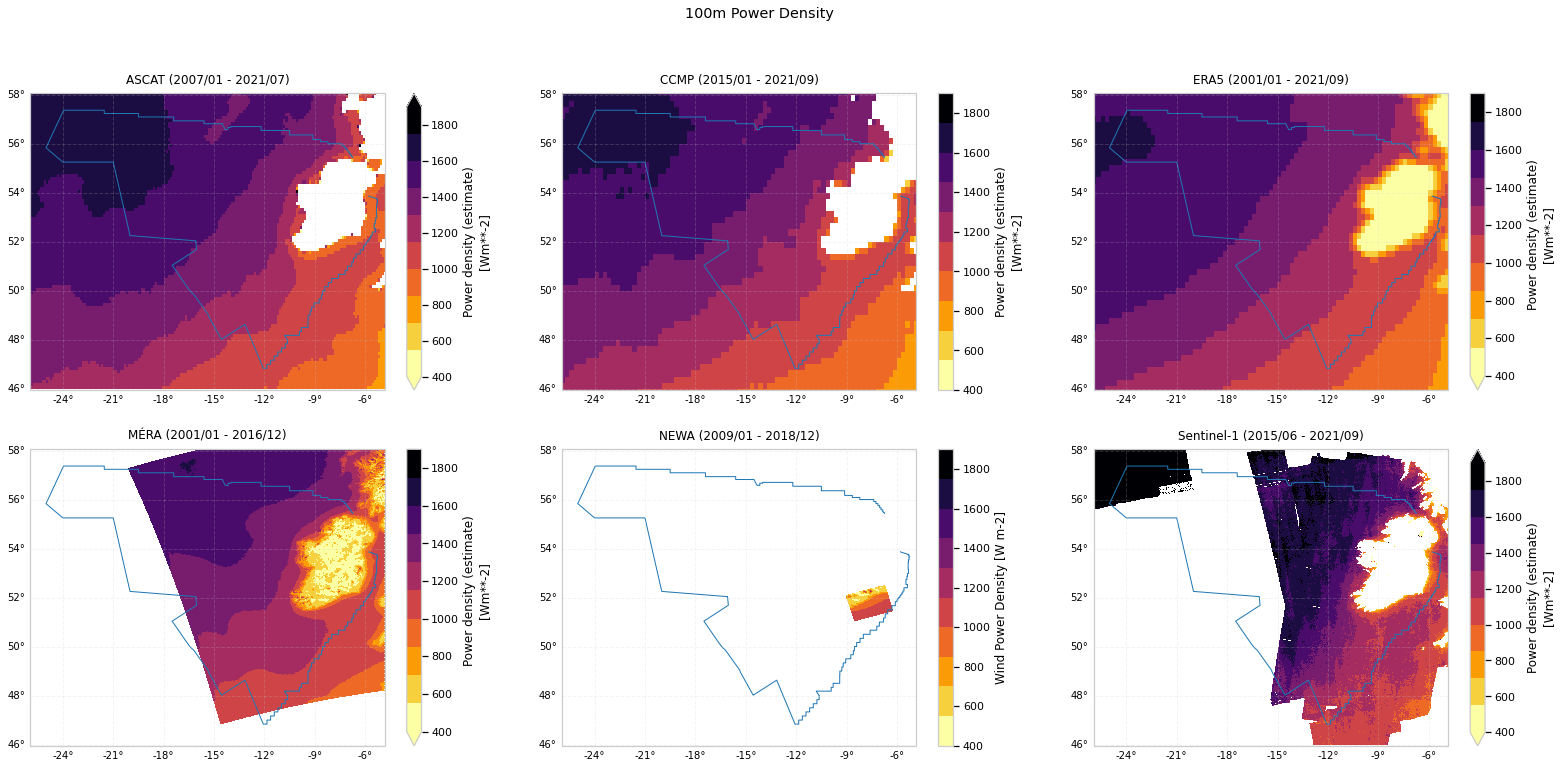

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(27, 12), subplot_kw=dict(projection=MAP_PROJECTION))
ax = ax.flatten()
height = 100
for i, eooffshoreds in enumerate(PLOT_ICS_DATASETS):
    power_density = eooffshoreds.dataset.power_density.sel(height=height)
    power_density = power_density.mean(dim='time', keep_attrs=True) if 'time' in power_density.dims else power_density
    plot_ics_variable(variable=power_density.compute(),
                      title=f'{eooffshoreds.name} ({format_plot_time(eooffshoreds.dataset.time.min())} - {format_plot_time(eooffshoreds.dataset.time.max())})',
                      vmin=400,
                      vmax=1900,
                      ax=ax[i],
                      cmap=plt.cm.get_cmap('inferno_r', 10)
                     )

fig.suptitle(f'{height}m Power Density');

------------------------------------------------
#### Seasonal 100m power density

Similiar to seasonal wind speed described above, seasonal power density may be calculated using [`xarray.DataArray.groupby()`](https://docs.xarray.dev/en/stable/examples/monthly-means.html) with the `Season` (`time.season`) dimension. This is demonstrated using the MÉRA dataset.

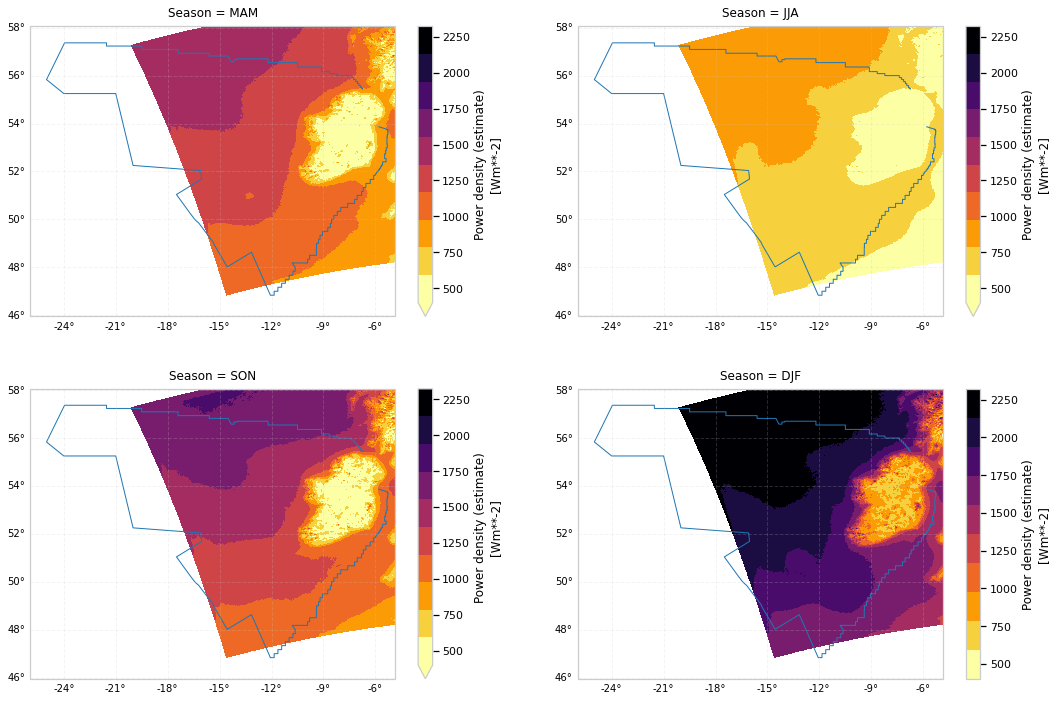

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), subplot_kw=dict(projection=MAP_PROJECTION))
axes = ax.flatten()
seasonws = mera.dataset.power_density.sel(height=100).groupby('Season').mean(keep_attrs=True).compute()
for i, season in enumerate(season_order):
    ax = axes[i]
    plot_ics_variable(ax=ax,
                      variable=seasonws.sel(Season=season), 
                      title=f'Season = {season}',
                      vmin=400,
                      vmax=seasonws.max().item(),
                      cmap=plt.cm.get_cmap('inferno_r', 10))
    plt.subplots_adjust(hspace=0.25)

----------------------------------------------
### Operational and Maximum Yield Frequency

Maps of operational and maximum yield frequency, as discussed by [Remmers et al., (2019)](https://doi.org/10.3390/en12020206), may also be generated for all data sets. These reflect the frequency at which power is generated, along with the maximum power yield:
* Operational: wind speed = [3, 25]
* Maximum yield: wind speed = [10, 25]

In [47]:
def plot_frequency(name: str, height: int, min_wind_speed: float, max_wind_speed: float, vmin: float, vmax: float):
    """Generate Operational/Maximum Yield frequency plots"""
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(27, 12), subplot_kw=dict(projection=MAP_PROJECTION))
    ax = ax.flatten()

    for i, eooffshoreds in enumerate(PLOT_ICS_DATASETS):
        wind_speed = eooffshoreds.dataset.wind_speed.sel(height=height)
    
        # Determine the number of observations per cell
        if eooffshoreds.incomplete_time_series:
            num_observations = wind_speed.where(wind_speed.fillna(-1)!=-1).count(dim='time')
            num_observations = num_observations.where(num_observations > 0, other=1).compute()
        else:
            num_observations = eooffshoreds.dataset.dims['time']

        frequency = (100 * (wind_speed.where((wind_speed >= min_wind_speed) & (wind_speed <= max_wind_speed)).count(dim='time') / num_observations))
        frequency.name = name
        frequency.attrs['units'] = '%'
    
        plot_ics_variable(variable=frequency.compute(),
                          title=f'{eooffshoreds.name} ({format_plot_time(eooffshoreds.dataset.time.min())} - {format_plot_time(eooffshoreds.dataset.time.max())})',
                          vmin=vmin,
                          vmax=vmax,
                          ax=ax[i],
                          cmap=plt.cm.get_cmap('viridis', 10)
                         )
    
    fig.suptitle(f'{height}m {name} - Wind Speed $\in$ $[{min_wind_speed}, {max_wind_speed}]$');

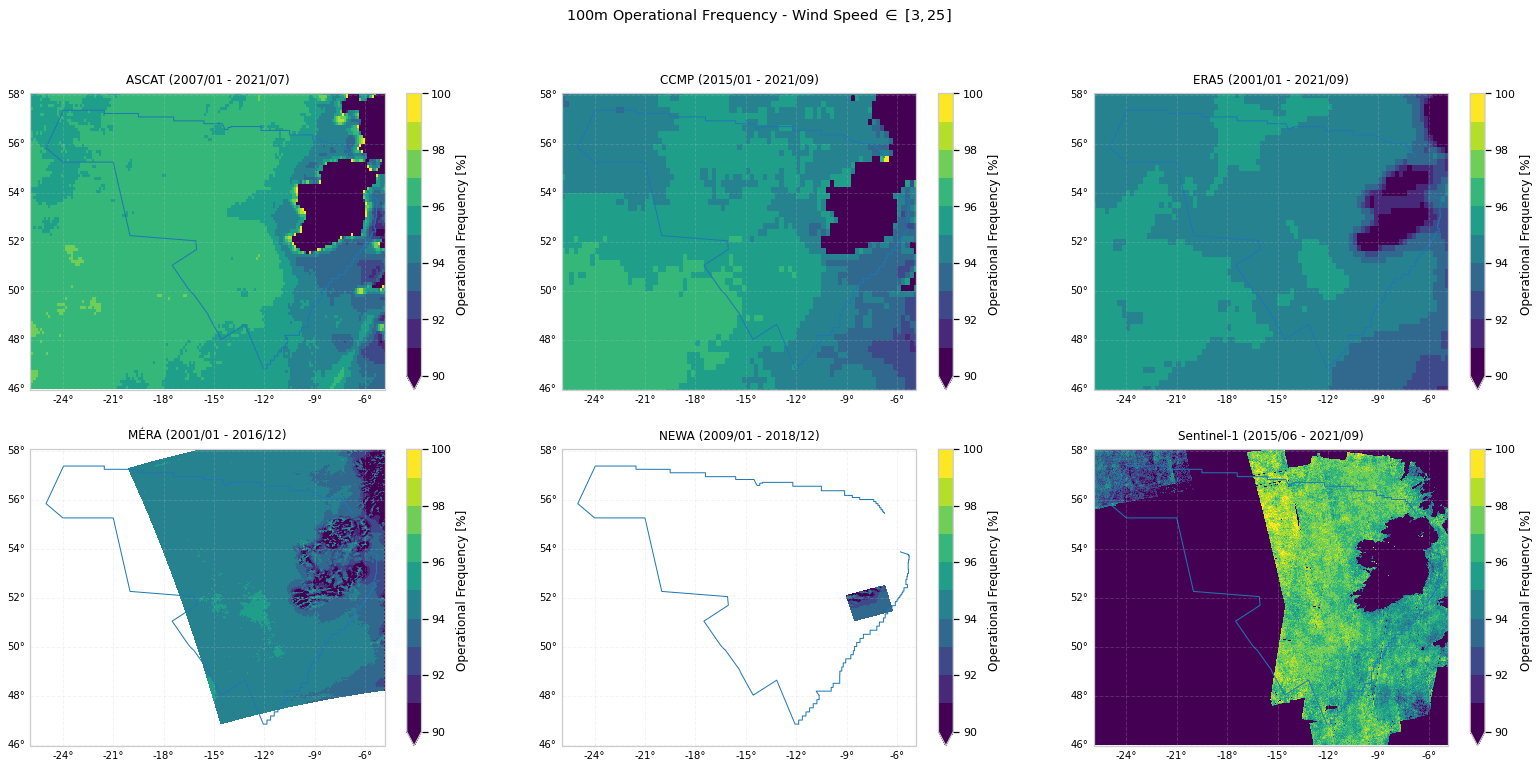

In [48]:
plot_frequency(name='Operational Frequency',
               height=100,
               min_wind_speed=CUT_IN_WIND_SPEED,
               max_wind_speed = CUT_OUT_WIND_SPEED,
               vmin=90,
               vmax=100)

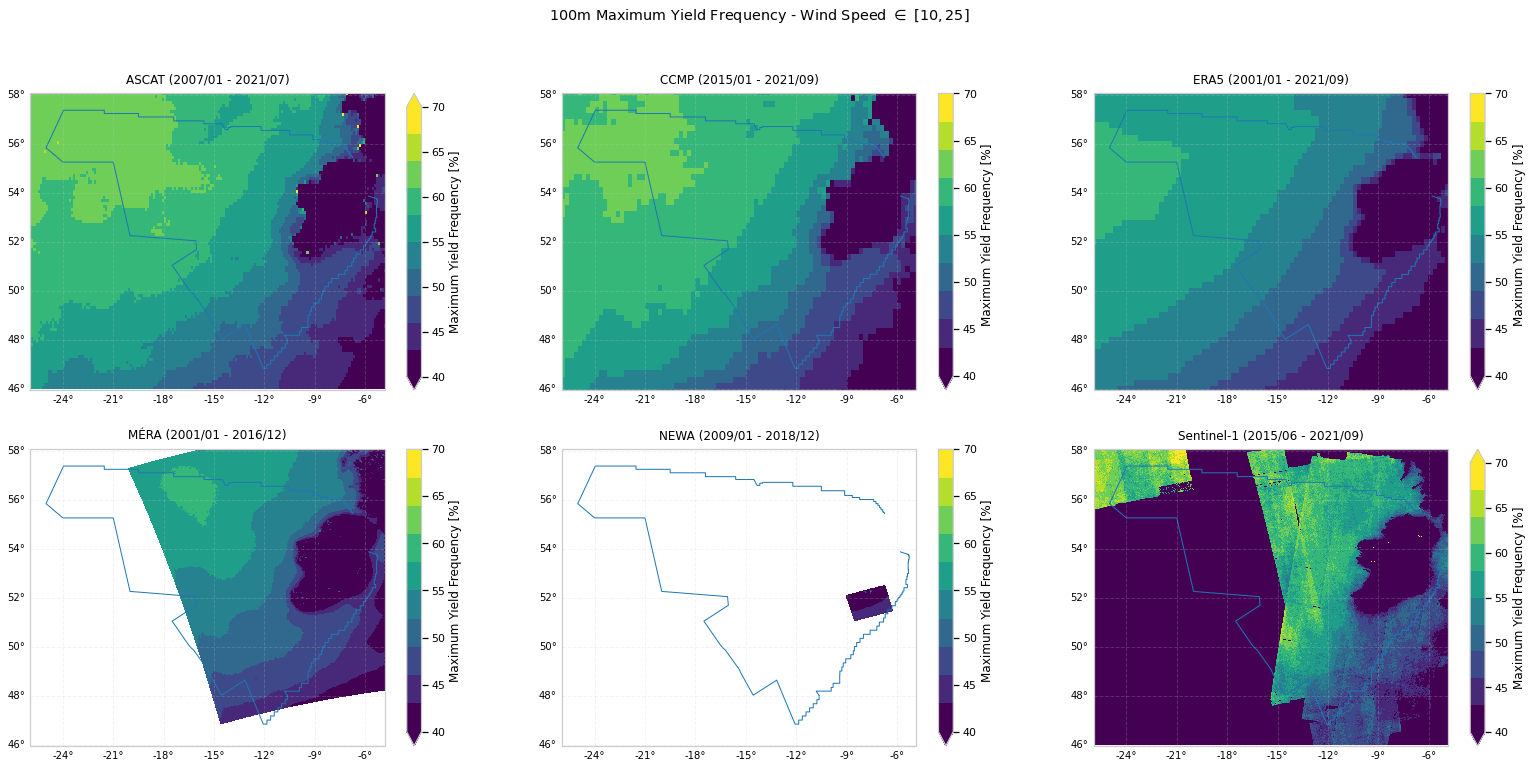

In [49]:
plot_frequency(name='Maximum Yield Frequency',
               height=100,
               min_wind_speed=10,
               max_wind_speed = CUT_OUT_WIND_SPEED,
               vmin=40,
               vmax=70)

-------------------------------
### AOI power density summary
Mean 100m power density ($Wm^{-2}$) for all buoy and wind farm AOIs
* `nan` values indicate no data was found for a particular AOI (see mean map plots above)

In [50]:
aoi_summary(datasets=DATASETS, variable='power_density', height=100).style.format('{:,.0f}')

---------------------------------
### Power density time series
Similar to wind speed time series above, using the `power_density` variable.
* Sentinel-1 is excluded as it uses the Weibull method for power density estimation, and consequently has no `time` dimension.

---------------------------------
#### 100m power density since 2001 for IWB buoys
Using the M2 buoy as an example IWB AOI

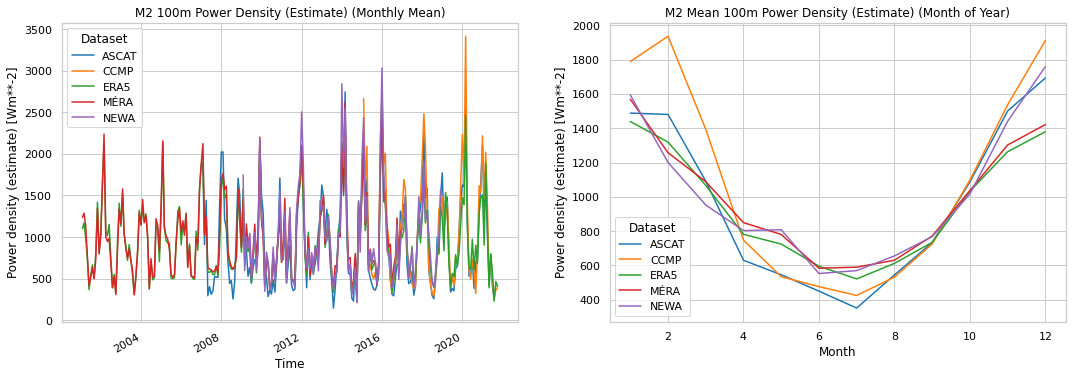

In [51]:
plot_buoy_aoi_summary(buoy='M2', datasets=[ascat, ccmp, era5, mera, newa], variable='power_density', height=100)

---------------------------------
#### 100m power density since 2001 for wind farms
Using the Celtic Sea 1 wind farm as an example AOI. Mean power density is calculated using corresponding wind farm grid coordinates spatial means.

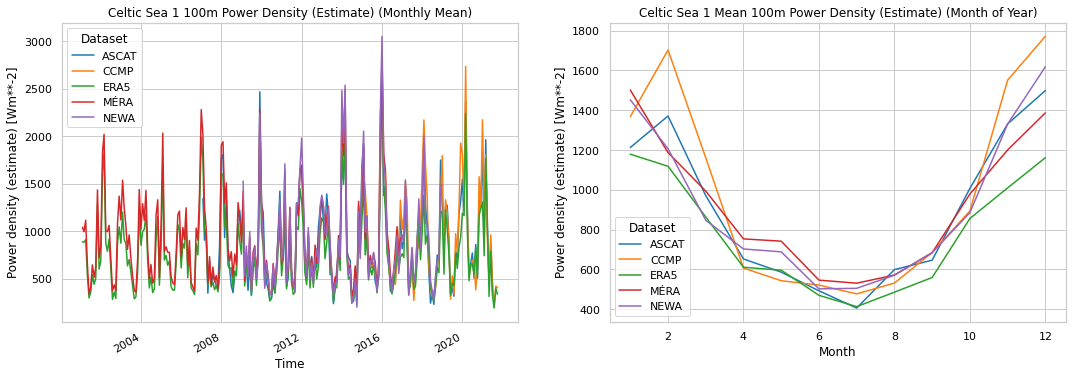

In [52]:
plot_windfarm_aoi_summary(windfarm='Celtic Sea 1', datasets=[ascat, ccmp, era5, mera, newa], variable='power_density', height=100)